# SIRD parameter learning using LM-BFGS with terminal target

$\newcommand{\R}{\,\mathbb{R}} \newcommand{\dif}{\mathrm{d}} \newcommand{\diag}{\mathrm{diag}} \newcommand{\vec}{\mathrm{vec}}  \newcommand{\circulant}{\mathrm{circ}} \newcommand{\mat}{\mathrm{mat}} \newcommand{\ifft}{\hat{\mathcal{F}}} \newcommand{\fft}{\mathcal{F}}$
<div class="alert alert-block alert-success">
This notebook aims to solve the minimisation problem
\begin{align}
    \min_{\alpha \in [0,1]^2} f(\alpha) = \frac{1}{2} \| \rho - \widehat{\rho} \|_2^2 + \frac{\theta}{2} \|\alpha\|^2 + \frac{\vartheta}{2} \| \rho(T) - \widehat{\rho}(T) \|^2_{\R^3},
\end{align}
where $\rho = (\begin{smallmatrix} S & I & R \end{smallmatrix})$ comes from the solution of the traditional forward Susceptibles, Infected, and Recovered (SIR) model, and $\widehat{\rho}$ is a target and known state. The regularisation parameters $\theta$ and $\vartheta$ are non negative. We will study the effect of this parameter on the choice of the control pair $\alpha$.
    
For each pair of parameters $\alpha = (\beta, \gamma) \in [0,1]^2$ corresponding to the transmission and the recovery rates, the three variables $S(t)$, $I(t)$, and $R(t)$ are governed by the following differential equations
    
\begin{align}
    \frac{\dif S}{\dif t} &= -\beta S I,
    \\
    \frac{\dif I}{\dif t} &= \beta S I - (\gamma+m) I,
    \\
    \frac{\dif R}{\dif t} &= \gamma I.
\end{align}
    
We note that $S + I + R = n$, where $n$ is the total population. 
    
</div>

In [1]:
# Packages
import time
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
from scipy.integrate import solve_ivp

In [3]:
# Single function imports
from numpy           import array, asarray, sin, cos, zeros, linspace, argmin, meshgrid, unravel_index
from numpy           import concatenate, minimum, maximum, exp, ones, eye, empty, append, diagflat, tril, triu
from numpy           import logical_and, where, allclose, full, clip, arctan, exp, pi, arange
from numpy.random    import default_rng as rng
from scipy.linalg    import norm, eigvals, inv
from scipy.integrate import simpson
from scipy.optimize  import minimize, Bounds
from matplotlib.cm   import get_cmap
from scipy.interpolate   import CubicHermiteSpline, interp1d
from scipy.sparse.linalg import LinearOperator
from numpy.polynomial.chebyshev import chebpts1

# Problem setup

In [4]:
# Total population
n = 200
# Initial conditions
f = 5e-2
Sₒ, Iₒ, Rₒ = (1-f)*n, f*n, 0.0    # These are for reference, changing them won't affect the later code
# Deceased rate
m = 0.1

In [5]:
ϑᵀᵉʳ = 0.01 * n
θ = 1e-4

## Generation of $\widehat \rho$

We are going to generate a choice for $\widehat\rho$ based on a solution of the system that satisfies the initial condition. For this, we find $\widehat\rho_{\mathsf e}$ as the solution of the SIR model for the choice $\alpha = (0.01,0.5)$. Then we will obtain $\widehat\rho = \widehat{\rho}_{\mathsf e} + 4\sin(\widehat{\rho}_{\mathsf e}) - 4\sin(\rho_0)$.

In [6]:
T  = 2.0                             # Final time
Tₑ = 0.5*(chebpts1(50000-2)+1) * T   # Evaluation interval using Chebyshev points of the first kind
Tₑ = concatenate([[0],Tₑ,[T]])       # Add endpoints

In [7]:
# Rates for ρ̂ₑ:
βₑ, γₑ = 0.01, 0.5
αₑ = asarray([βₑ, γₑ])

In [8]:
print('Basic reproduction number:', n*βₑ/(γₑ+m))

Basic reproduction number: 3.3333333333333335


In [9]:
def SIR(t, z, β,γ):
    S, I, R = z
    return [-β*S*I, β*S*I - γ*I - m*I, γ*I]

In [10]:
sol = solve_ivp(SIR, [0, T], [Sₒ, Iₒ, Rₒ], args=(βₑ, γₑ), t_eval = Tₑ, dense_output=True, vectorized=True)
print(sol['message'])

The solver successfully reached the end of the integration interval.


In [11]:
ρ̂ₑ  = sol.y;    ρ = ρ̂ₑ.copy()
dρ̂ₑ = asarray(SIR(0,ρ̂ₑ,βₑ,γₑ))

Apply smooth transformation:

In [12]:
global ρ̂, ρ̄ₙ

In [13]:
ρ̂ = ρ̂ₑ + 4*sin(ρ̂ₑ) - 4*sin(ρ̂ₑ[:,0])[::,np.newaxis]

This target is continuously differentiable, as we have that
\begin{align}
\frac{\dif }{\dif t} [y + 4\sin(y)] = y' + 4\cos(y) y'
\end{align}
hence, we can still use an Hermite interpolator.

In [14]:
dρ̂ = dρ̂ₑ + 4*cos(ρ̂ₑ)*dρ̂ₑ

Create an abstract interpolator for state:

In [15]:
ρₜ = CubicHermiteSpline(Tₑ, ρ̂ₑ, dρ̂ₑ, axis=-1)
ρ̄ = CubicHermiteSpline(Tₑ, ρ̂, dρ̂, axis=-1)
ρ̄ₙ = CubicHermiteSpline(Tₑ, ρ̂, dρ̂, axis=-1)   # Copied here just to remember global property
dρ̄ = interp1d(Tₑ, dρ̂, axis=-1)

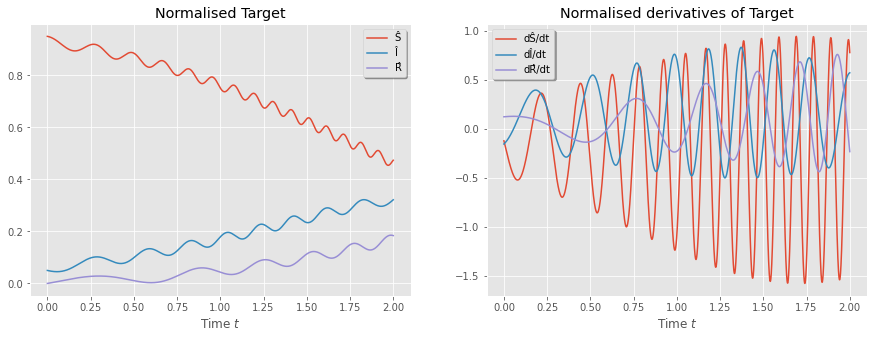

In [16]:
# Plot Target curves
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(Tₑ, ρ̂.T/n)
plt.xlabel(r'Time $t$')
plt.legend(['Ŝ', 'Î', 'R̂'], shadow=True)
plt.title('Normalised Target')

plt.subplot(1, 2, 2)
plt.plot(Tₑ, dρ̂.T/n)
plt.xlabel(r'Time $t$')
plt.legend(['dŜ/dt', 'dÎ/dt', 'dR̂/dt'], shadow=True)
plt.title('Normalised derivatives of Target')
plt.show()

## Adjoint system

The adjoint state can be found by solving the following ODE system:

\begin{align}
    \frac{\dif q_S}{\dif t} &= \hat{S} - S +\beta I(q_S - q_I),
    \\
    \frac{\dif q_I}{\dif t} &= \hat{I} - I + \beta S(q_S - q_I) + \gamma (q_I - q_R) + m q_I,
    \\
    \frac{\dif q_R}{\dif t} &= \hat{R} - R,
\end{align}
with the terminal condition $q(T) = \vartheta\big[\rho(T) - \widehat{\rho}(T)\big]$.

Let us see how we can implement this with an adaptive step method:

In [17]:
def Adjoint(t, z, β,γ,ρ,ρ̄):
    S̄, Ī, R̄ = ρ̄(t)    # Target
    S, I, R = ρ(t)     # State
    qₛ, qᵢ, qᵣ = z     # Adjoint
    return [S̄ - S + β*I*(qₛ - qᵢ), Ī - I + β*S*(qₛ - qᵢ) + γ*(qᵢ - qᵣ) + m*qᵢ, R̄ - R]

Let us try solving this problem for $\rho = \widehat{\rho}$:

In [18]:
qₒ = ϑᵀᵉʳ*(ρ̂[:,-1] - ρ̂ₑ[:,-1])
solₛ = solve_ivp(Adjoint, [T,0], qₒ, args=(αₑ[0],αₑ[1],ρₜ,ρ̄), t_eval = Tₑ[::-1], dense_output=True, vectorized=True)
print(solₛ['message'],'There were',solₛ.nfev,'function evaluations.')

The solver successfully reached the end of the integration interval. There were 128 function evaluations.


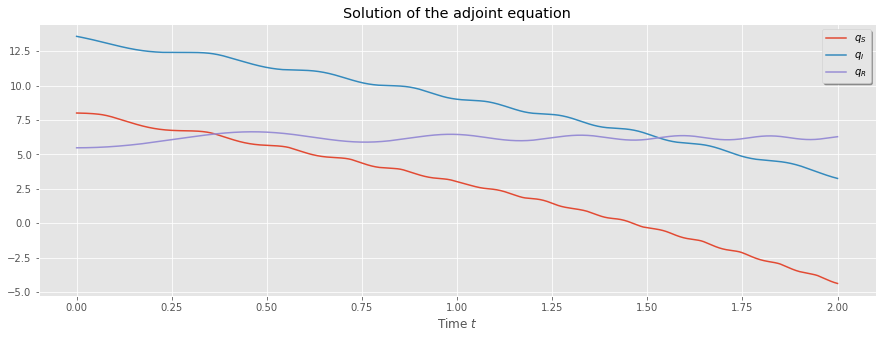

In [19]:
# Plot adjoint curves
plt.figure(figsize=(15,5))
plt.plot(Tₑ[::-1],solₛ.y.T)
plt.xlabel(r'Time $t$')
plt.legend([r'$q_S$', '$q_I$', '$q_R$'], shadow=True)
plt.title('Solution of the adjoint equation')
#plt.yscale('log')
plt.show()

Now we try to optimise the function
\begin{align}
    f(\alpha) = \frac{1}{2} \int\limits_0^T \big( S(t) - \hat{S}(t) \big)^2 + \big( I(t) - \hat{I}(t) \big)^2 + \big( R(t) - \hat{R}(t) \big)^2 \,\dif t + \frac{\theta}{2} ( \beta^2 + \gamma^2 ) + \frac{\vartheta}{2} \| \rho(T) - \widehat{\rho}(T) \|^2_{\R^3}.
\end{align}

In [20]:
α = αₑ.copy()

In [21]:
def Objective(ρ,ρ̂,α, θ,ϑᵀᵉʳ,Tₑ):    return 0.5 * (simpson((ρ-ρ̂)**2,Tₑ).sum() + θ * (α**2).sum()
                                                     + ϑᵀᵉʳ * ((ρ̂[:,-1] - ρ[:,-1])**2).sum() )
# This one can be two times faster:
#def Objective(ρ,ρ̂,α, θ):    return 0.5 * (simpson(((ρ-ρ̂)**2).sum(0),Tₑ) + θ * (α**2).sum())

In [22]:
def proj(α):    return minimum(maximum(α,0.0),1.0)

In [23]:
print('As an example, the distance between ρ and ρ̂ is {0:.4f}.'.format( Objective(ρ,ρ̂,α,θ,ϑᵀᵉʳ,Tₑ) ))

As an example, the distance between ρ and ρ̂ is 61.4051.


Now we can compute the derivative of the reduced objective functional [ ! ]:
\begin{align}
    \frac{\partial f}{\partial \beta} &= \int\limits_0^T S I( q_I - q_S ) \, \dif t + \theta \beta
    \\
    \frac{\partial f}{\partial \gamma} &= \int\limits_0^T I( q_R - q_I ) \, \dif t  + \theta \gamma
\end{align}

In [24]:
q = solₛ.y[:,::-1]

In [25]:
df = asarray([simpson(ρ[0]*ρ[1] * (q[1]-q[0]), Tₑ) + θ * α[0], simpson(ρ[1] * (q[2]-q[1]), Tₑ) + θ * α[1]])
display(df.tolist())

[60225.89864217478, -86.95816391485188]

# Surfaces

We can observe what happens with the cost functional for different values of the hyperparameter $\alpha$:

In [26]:
global ρ, q
ρ, q = empty((3, Tₑ.size), np.float64), empty((3, Tₑ.size), np.float64)

In [27]:
def obj_eval(α):                  # ** Eval f and f' ** #
    global ρ, q, df,  ρ̂, ρ̄ₙ
    '''
        Evaluate state, compute adjoint, and return objective and derivative
    '''
    scaling = True
    
    # Compute state α
    ρ_sol = solve_ivp(SIR, [0, T], [Sₒ, Iₒ, Rₒ], args=α, t_eval = Tₑ, 
                      dense_output=True, vectorized=True)
    if ρ_sol['success'] != True:    print('Should re-evaluate for', α)
    ρ = ρ_sol.y
    f = Objective(ρ,ρ̂,α, θ,ϑᵀᵉʳ,Tₑ)
    f /= (n**2) if scaling else 1.0
    
    # Create an abstract interpolator for state
    ρₜ = CubicHermiteSpline(Tₑ, ρ, asarray(SIR(0,ρ,α[0],α[1])), axis=-1)
    
    # Compute adjoint
    qₒ = ϑᵀᵉʳ*(ρ[:,-1] - ρ̂[:,-1])       # Terminal condition of adjoint
    q_sol = solve_ivp(Adjoint, [T,0], qₒ, args=(α[0], α[1], ρₜ, ρ̄ₙ), t_eval = Tₑ[::-1], 
                      dense_output=True, vectorized=True)
    q = q_sol.y[:,::-1]

    # Compute derivative
    df  = asarray([simpson(ρ[0]*ρ[1] * (q[1]-q[0]), Tₑ), simpson(ρ[1] * (q[2]-q[1]), Tₑ)])
    df += (θ * α)
    df /= (n**2) if scaling else 1.0
    
    return asarray(f), df
def obj_eval_a(α):                # ** Eval just f ** #
    global ρ, ρ̂
    '''
        Evaluate state and return objective
    '''
    scaling = True
    
    # Compute state α
    ρ_sol = solve_ivp(SIR, [0, T], [Sₒ, Iₒ, Rₒ], args=α, t_eval = Tₑ, 
                      dense_output=True, vectorized=True)
    if ρ_sol['success'] != True:    print('Should re-evaluate for', α)
    ρ = ρ_sol.y
    f = Objective(ρ,ρ̂,α, θ,ϑᵀᵉʳ,Tₑ)
    f /= (n**2) if scaling else 1.0
    
    return asarray(f)
def obj_eval_b(α):                # ** Does not affect global variable ρ ** #
    global ρ̂
    '''
        Evaluate state, compute adjoint, and return objective and derivative
    '''
    scaling = True
    
    # Compute state α
    ρ_sol = solve_ivp(SIR, [0, T], [Sₒ, Iₒ, Rₒ], args=α, t_eval = Tₑ, 
                      dense_output=True, vectorized=True)
    if ρ_sol['success'] != True:    print('Should re-evaluate for', α)
    ρₐ = ρ_sol.y
    f  = Objective(ρₐ,ρ̂,α, θ,ϑᵀᵉʳ,Tₑ)
    f /= (n**2) if scaling else 1.0

    return f
def obj_eval_d(α):                # ** Does not affect global variables ρ, q, df ** #
    global ρ̂, ρ̄ₙ
    '''
        Evaluate state, compute adjoint, and return objective and derivative
    '''
    scaling = True
    
    # Compute state α
    ρ_sol = solve_ivp(SIR, [0, T], [Sₒ, Iₒ, Rₒ], args=α, t_eval = Tₑ, 
                      dense_output=True, vectorized=True)
    if ρ_sol['success'] != True:    print('Should re-evaluate for', α)
    ρₐ = ρ_sol.y
    f  = Objective(ρₐ,ρ̂,α, θ,ϑᵀᵉʳ,Tₑ)
    f /= (n**2) if scaling else 1.0
    
    # Create an abstract interpolator for state
    ρₜ = CubicHermiteSpline(Tₑ, ρₐ, asarray(SIR(0,ρₐ,α[0],α[1])), axis=-1)
    
    # Compute adjoint
    qₒ = ϑᵀᵉʳ*(ρₐ[:,-1] - ρ̂[:,-1])       # Terminal condition of adjoint
    q_sol = solve_ivp(Adjoint, [T,0], qₒ, args=(α[0], α[1], ρₜ, ρ̄ₙ), t_eval = Tₑ[::-1], 
                      dense_output=True, vectorized=True)
    q̂ = q_sol.y[:,::-1]

    # Compute derivative
    dF = asarray([simpson(ρₐ[0]*ρₐ[1] * (q̂[1]-q̂[0]), Tₑ), simpson(ρₐ[1] * (q̂[2]-q̂[1]), Tₑ)])
    dF += (θ * α)
    dF /= (n**2) if scaling else 1.0

    return f, dF

---

In [28]:
# Coarse evaluations
nβ, nγ = 51, 51
Misfit, Reprod = zeros([2, nβ, nγ])
β_axis = linspace(0.00,1,nβ)
γ_axis = linspace(0.02,1,nγ)
for (i,β) in enumerate(β_axis):
    for (j,γ) in enumerate(γ_axis):
        Misfit[i,j] = obj_eval_a( asarray([β,γ]) ).item()
        Reprod[i,j] = n * β / (γ + m)
i_0 = unravel_index(argmin(Misfit),  Misfit.shape)                     # finer mesh
M_0, β_0, γ_0 = Misfit[i_0],    β_axis[i_0[0]],    γ_axis[i_0[1]]

In [29]:
print('Smallest objective found in the mesh: {0};'.format(M_0),'(β,γ):',β_axis[i_0[0]],γ_axis[i_0[1]])

Smallest objective found in the mesh: 0.38553806729970264; (β,γ): 0.02 1.0


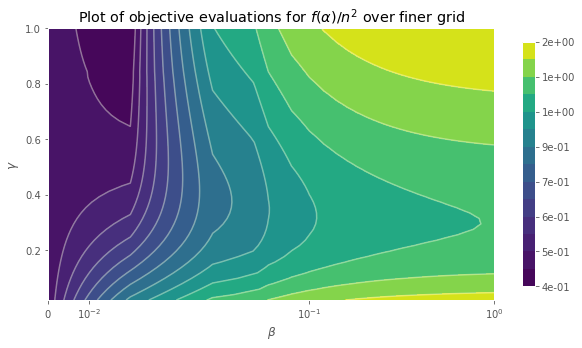

In [30]:
# Contour plot objective functional
X_c, Y_c = meshgrid(β_axis, γ_axis, indexing='ij')
ℓ = linspace((Misfit).min(),(Misfit).max(),15)
ℓ = np.logspace( np.log( Misfit.min() ), np.log( Misfit.max() ), num=15, endpoint=True, base=np.e)

fig, ax = plt.subplots(ncols=1, figsize=(10, 5))
cp = ax.contourf(X_c, Y_c, Misfit, ℓ)
ax.contour(cp, colors='#FFFFE6', alpha= 0.4)                                  # Contour plot
#plt.scatter(β_0, γ_0, s=20, c='#FFFFE6', marker='s')          # Display min
#plt.scatter(ᾱ[0], ᾱ[1], s=20, c='#FFFFE6', marker='x')          # Display min
fig.colorbar(cp, shrink=0.9, format='%.0e')
ax.set_xlabel(r'$\beta$');    ax.set_ylabel(r'$\gamma$')
plt.title(r'Plot of objective evaluations for ${f(\alpha)}/{n^2}$ over finer grid')
plt.xscale('symlog', linthresh = 5e-2)
#plt.xscale('log')
plt.show()
#fig.savefig('contour_coarse.pdf', bbox_inches='tight', pad_inches=0)

# Solving the optimisation problem

In [31]:
Nᴹᵃˣ = 50000   # Resolution of target

In [32]:
Nᴿᵃⁿᵍᵉ = asarray([50, 100, 500, 1000, 5000, 10000, 50000])

In [33]:
N = Nᴿᵃⁿᵍᵉ[0]

In [34]:
# Evaluation interval using Chebyshev points of the first kind
Tₑ = concatenate([[0],0.5*(chebpts1(N-2)+1) * T,[T]])

In [35]:
ρ̂  = ρ̄(Tₑ)           # Sample target
dρ̂ = dρ̄(Tₑ)          # Sample derivative of target (just for resolution of interporlator)

In [36]:
ρ̄ₙ = CubicHermiteSpline(Tₑ, ρ̂, dρ̂, axis=-1)        # Create interpolator for the sampled data

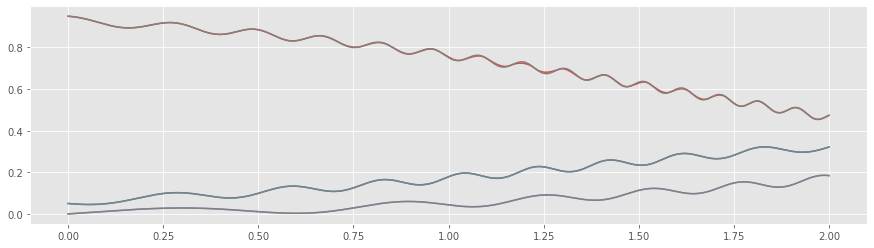

In [37]:
# We can see the differences between the ground truth and the interpolated curves:
Tᴹᵃˣ = concatenate([[0],0.5*(chebpts1(50000-2)+1) * T,[T]])
plt.figure(figsize=(15,4));   plt.plot(Tᴹᵃˣ, ρ̄ₙ(Tᴹᵃˣ).T/n);    plt.plot(Tᴹᵃˣ,  ρ̄(Tᴹᵃˣ).T/n, 'gray');    plt.show()

## Optimisation routine

We will use a trust region limited memory algorithm for optimising $f$. In this setting, we will write $x_k$ for the iterates $\alpha_k$.

Following the work of Yuan et al (2014), assuming 0 and $1$ as lower and upper bounds, respectively,
we introduce the quantity $x_k := \min\big\{\beta_k, c \|\nabla f(x_k)\|\big\} $, where $\beta_k$ and $c$ are positive constants such that $ 0 < \beta_k < \frac{1}{2} $, and define the strongly-active and inactive index sets by
\begin{align}
    A_k &:= \big\{ i \in \{1, \dots,n\}: \, x_{k,i} 
            \leq \xi_k \lor x_{k,i} \geq 1 -  \xi_k \big\},	
            \label{ec:active_set}
    \tag{1.a}
    \\
    I_k &:= \{1, \dots,n\} \setminus A_k = 
            \big\{ i \in \{1, \dots,n\}: \, \xi_k < x_{k,i} < 1 -  \xi_k \big\},	\label{ec:inactive_set}
    \tag{1.b}
\end{align}
respectively, where $x_{k,i}$ is the $i$-th element of $x_k$.
Now, suppose the current trust region radius is $\widehat\Delta >0$, with its maximum value $\Delta_{\max} > 0$, and let $\kappa > 0$. We can obtain a search direction at step $x_k$ as follows:

* **Projected gradient direction:** Compute
\begin{equation}\label{ec:proy_grad}
d^G_{*k} (\widehat\Delta) := \max\left\{ 0, \min\left\{1 , \,x_k - \dfrac{\widehat\Delta}{\Delta_{\max}}  \kappa_k \nabla f(x_k) \right\} \right\} - x_k.
\tag{PG}
\end{equation}

* **Projected trust-region direction:** We look for a direction $d^{\text{tr}}_{*k} (\widehat\Delta)$ defined for each index of the sets $A_k$ and $I_k$, respectively.
We begin with $A_k$, for which we let $v_k^{A_k}$ be the subvector
\begin{equation}
    v_k^{A_k} :=
    \begin{cases}
        x_{k,i}     & \text{if } x_{k,i} \leq \xi_k,  \\
        1 - x_{k,i} & \text{if } x_{k,i} \geq 1 - \xi_{k}.
    \end{cases}
\end{equation}
Then we define the subvector
\begin{equation}
    d^{A_k}_{*k} (\widehat\Delta)  := \min \left\{ 1, \dfrac{\widehat\Delta}{\|v_k^{A_k}\|} \right\} v_k^{A_k}.
    \tag{SV}
\end{equation}
For the inactive set $I_k$ we solve a reduced trust-region subproblem. Here, let $B_k$ be partitioned into two submatrices $B_k^{A_k} $ and $B_k^{I_k} $, obtained by taking columns of $B_k$ indexed by $A_k$ and $I_k$, respectively. Let $ d^{I_k}_{*k} (\widehat\Delta) $ be a solution of the following TR–subproblem
\begin{equation} \label{ec:subvector_inactive}
\begin{aligned}
        \min \;\, & d^\top \Big[ \big(B_k^{I_k}\big)^\top \big( \nabla f(x_k) + B_k^{A_k} d^{A_k}_{*k}  \big) \Big] + \dfrac{1}{2} d^\top \big(B_k^{I_k}\big)^\top B_k^{I_k} d\\
\text{s.t. } & \|d\| \leq \widehat\Delta.
\end{aligned}
\tag{TR}
\end{equation}
The projected trust-region direction is then defined as
\begin{equation}
    d^{\text{tr}}_{*k} (\widehat\Delta) := \max\left\{ 0, \min\left\{ 1, \, x_k + \begin{pmatrix} d^{A_k}_{*k} (\widehat\Delta) \\ d^{I_k}_{*k} (\widehat\Delta)  \end{pmatrix}\right\} \right\} - x_k.
\end{equation}
Since this direction may not be a descent direction for $f$ for far iterates, we use a convex combination with the gradient direction as follows.

* **Search direction:** Let
\begin{equation}
d_{* k} (\widehat\Delta)  := t_{*k} d_{*k}^G(\widehat\Delta) + (1- t_{*k}) d^{\text{tr}}_{*k} (\widehat\Delta),
	\end{equation}
	where $t_{*k}$  is a solution of the following one-dimensional problem
	\begin{equation}\label{ec:search_dir_one_dim}
		\min_{t \in [0,1]} f\big( x_k + t d_{*k}^G(\widehat\Delta) + (1- t) d^{\text{tr}}_{*k} (\widehat\Delta) \big).
        \tag{SD}
	\end{equation}

<div class="alert alert-block alert-warning">
Yuan, G., Wei, Z. & Zhang, M. An active-set projected trust region algorithm for box constrained optimization problems. J Syst Sci Complex 28, 1128–1147 (2015). https://doi.org/10.1007/s11424-014-2199-5
</div>

<div style="background-color:rgba(0, 0, 0, 0.0470588); vertical-align: middle; padding:5px 0; padding-left: 40px;">
<h2 style="color: #5e9ca0;">Projected Trust-Region Algorithm with L-BFGS Update</h2>
<ol>
<li>Choose \(x_0 \) and a symmetric positive definite matrix \(H_0\). Let constants satisfy \(0 < \beta_0 < \frac{1}{2} \), \(c>0\), \(0 < \nu_1 < 1 < \nu_2\), \(0<\tau_1<\tau_2<1\), \(\upsilon \in (0,1)\), \(\omega \in \mathbb{R}\), \(\Delta_0 >0\), and \( \Delta_{\max} > \Delta_{\min} > 0\). Now set \(m \in \mathbb{N}\), \(k = 0\), and \(B_0 =H_0^{-1}\)
    </li>
    
<p><bf> \(\mathbf{Repeat}\)</bf></p>
    
<ol>
<li>
    Let \(\Delta_k := \min\big\{ \Delta_{\max}, \max\{\Delta_{\min}, \Delta_k\} \big\}\) and \(\widetilde\Delta = \Delta_k\).
</li>
    
<li> Determine index sets \(A_k\) and \(I_k\) by (1.a) and (1.b).
</li>
    
<li> Find \(d_{*k}^{\text{tr}} (\widetilde\Delta)\) by determining \(d_{*k}^{A_k} (\widetilde\Delta)\) and \(d_{*k}^{I_k} (\widetilde\Delta)\) as in (SV) and (TR).
</li>
    
<li> Set
    \[
        \kappa_k := \min\left\{ 1, \dfrac{\Delta_{\max}}{\big\| \nabla j(x_k) \big\|}, \dfrac{\omega}{\big\| \nabla j(x_k) \big\|} \right\}.
    \]
</li>


<li>Compute \( d_{*k}^G(\widetilde\Delta)\) and \(t_{*k}\) as in (PG) and (SD), respectively. Let
    \[
        d_{*k} (\widehat\Delta)  := t_{*k} d_{*k}^G(\widehat\Delta) + (1- t_{*k}) d^{\text{tr}}_{*k} (\widehat\Delta).
    \]
</li>
    
    
<li>Compute
    \[
        r_{*k} := \dfrac{ j(x_k + d_{*k}) - j(x_k)}{ \nabla j(x_k)^\top d_{*k} (\widehat\Delta) + \frac{1}{2} \, d_{*k} (\widehat\Delta)^\top B_k d_{*k} (\widehat\Delta)}
    \]
</li>
    
    
<li> \(\mathbf{If}\) \(j(x_k) - j \big(x_k + d_{*k} (\widehat\Delta) \big) \geq -\upsilon \nabla j (x_k)^\top d^G_{*k} (\widehat\Delta)\) and \(r_{*k} \geq \tau_1\) hold \(\mathbf{then}\)
</li>
    
<ol>
    <li> Let \(q_k := d_{*k}\), \(x_{k+1} := x_k + d_{*k}\), \(\beta_k = \widehat\Delta \), and
        \[
            \Delta_{k+1} :=
            \begin{cases}
                \widehat\Delta & \text{if } \tau_1 < r_{*k} < \tau_2,
                \\
                \nu_2 \widehat\Delta & \text{if } r_{*k} \geq \tau_2.
            \end{cases}
        \]
    </li>
    <li> Let \(\widehat m := \min\{k+1,m\}\). </li>
    <li> Update \(B_k\) with the \(n \times \widehat m\) matrices \(S_k\) and \(Y_k\) to get \(B_{k+1} \). </li>
    <li> Let \(k = k+1\) and return to step A. </li>
</ol>
    

    
<li> \(\mathbf{else}\) </li>
<ol>    
    <li>Let \(\widehat\Delta = \tau_1 \widehat\Delta\). </li>
<li> Return to step C.</li>
</ol>
</ol>
    
<p><bf> \(\mathbf{until}\, x_{k}\) satisfies some stopping criteria.</bf></p>
</div>

<div class="alert alert-block alert-warning">
<b>Limited memory</b>
</div>

The limited memory BFGS method approximates the inverse of the Hessian of a functional $j$ at iteration $k+1$, say $H_{k+1}$, without storing the dense matrices $H_k$ at each iteration. Instead, it stores $m$ correction pairs $ \{q_i, d_i\}_{i\in [k-1: k-m]} \subset\mathbb{R}^{n,2} $, where
\begin{equation}
    q_i := x_{i+1} - x_{i}
    \qquad\text{and}\qquad
    d_i := \nabla f(x_{i+1}) - \nabla f(x_{i}),
\end{equation}
that contain information related to the curvature of $f$. Byrd et al (1994) introduced a compact form to define the limited memory matrix $ B_k = H_k^{-1} $ in terms of the $ n\times m $ correction matrices
\begin{equation}
    S_k :=
        \begin{pmatrix}
            q_{k-m} & \cdots & q_{k-1}
        \end{pmatrix}
    \qquad\text{and}\qquad
    Y_k :=
        \begin{pmatrix}
            d_{k-m} & \cdots & d_{k-1}
        \end{pmatrix}.
\end{equation}
%
The main idea of the algorithm is that the matrix $S_k^\top Y_k$ can be written as the sum of the following three matrices:
\begin{equation}
    S_k^\top Y_k = L_k + D_k + R_k,
\end{equation}
where $L_k$ is strictly lower triangular, $D_k$ is diagonal, and $R_k$ is strictly upper triangular.

For $\theta > 0$, if the correction pairs satisfy $ q_i^\top d_i > 0 $, then the matrix obtained by updating $\theta I_n$ with the BFGS formula and the correction pairs after $k$-times can be written as
\begin{align}
    B_k &:= \theta I_n - W_k M_k W_k^\top,
\end{align}
where $W_k$ and $M_k$ are the block matrices given by
\begin{align}
W_k &:= \begin{pmatrix}	Y_k & \theta S_k \end{pmatrix},
\\
M_k &:= \begin{pmatrix}	-D_k & L_k^\top \\  L_k &  \theta S_k^\top S_k	\end{pmatrix}^{-1}.	\label{lbfgs-Bc}
\end{align}
Note that, as $M_k$ is a $2m\times 2m$ matrix, the cost of computing the inverse in the last formula is negligible. Hence, using the compact representation for $B_k$, various computations involving this matrix become inexpensive, as is the case of the product of $B_k$ times a vector.

One aspect of the BFGS method is that each update is positive definite. As the limited memory formula for $B_k$ can also be stated as
\begin{equation}
	B_k = V_k^\top H_k V_k + p_k q_k q_k^\top,
\end{equation}
with $ p_k := \big( q_k^\top d_k \big)^{-1}$ and $V_k :=  I_n - p_k d_k q_k^\top$. Thus, we can guarantee positive definiteness using Powell's method in which $d_k$ is redefined as
\begin{equation}
	d_k :=
	\begin{cases}
		d_k		& \text{if } q_k^\top d_k \geq 0.2 q_k^\top B_k d_k,
		\\
		\alpha_k d_k + (1-\alpha_k) B_k q_k & \text{otherwise},
	\end{cases}
\end{equation}
where $\alpha_k := \frac{0.8 q_k^\top B_k q_k}{q_k^\top B_k q_k - q_k^\top d_k}$. If the updated $q_k^\top d_k$ is too close to zero, to maintain numerical stability, the limited memory matrix is not updated.

<div class="alert alert-block alert-warning">
Richard H. Byrd, Jorge Nocedal, and Robert B. Schnabel. Representations of quasi-Newton matrices and their use in limited memory methods. Mathematical Programming, 63(1- 3):129–156, jan 1994.
</div>

In [38]:
β, γ = α = rng(0).uniform(0,1,2)              # Initial point

In [39]:
dim = 2            # dimension of the parameter to optimise 

A Limited Memory BFGS method is used. The matrices will be constantly updated.

In [40]:
'''Functions needed for LM operations'''
def Limited():
    def B_eval(W,MI,dk):
        db  = dk.copy();         db *= θᵪ;        db -= W.dot(MI.dot(W.T.dot(dk)));            return db
    def BA_eval(W,MI,Uk,dUk):
        db = zeros(dim, dtype='float')
        db[Uk] = dUk;            db *= θᵪ;        db -= W.dot(MI.dot(W[Uk,:].T.dot(dUk)));     return db
    def BAT_eval(W,MI,Uk,dUk):
        db = dUk[Uk].copy();     db *= θᵪ;        db -= W[Uk,:].dot(MI.T.dot(W.T.dot(dUk)))
        return db
    def H_eval(WH,MH,dk):
        db  = dk.copy();         db /= θᵪ;        db += WH.dot(MH.dot(WH.T.dot(dk)));          return db
    def HA_eval(WH,MH,Uk,dUk):
        db = zeros(dim, dtype='float');   db[Uk] = dUk;    db /= θᵪ;    db += WH.dot(MH.dot(WH[Uk,:].T.dot(dUk)))
        return db
    def HAT_eval(WH,MH,Uk,dUk):
        db = dUk[Uk].copy();     db /= θᵪ;     db += WH[Uk,:].dot(MH.T.dot(WH.T.dot(dUk)));   return db
    return B_eval, BA_eval, BAT_eval, H_eval, HA_eval, HAT_eval

In [41]:
def LBFGS(S,Y,SY, θ):
    W   = append(Y, θ*S, axis=1);  np.dot(S.T, Y, out=SY);  L = tril(SY,k=-1);  D = diagflat(SY.diagonal())
    M0  = append(-D,L.T, axis=1);    M1 = append(L, θ*S.T.dot(S), axis=1);    MM = append(M0,M1, axis=0)
    MI  = inv(MM)
    WH  = W.copy();       WH /= θ;    R = inv(triu(SY,k=0));            MH0 = append(O, -R, axis=1)
    MH1 = append(-R.T, R.T.dot((D + Y.T.dot(Y)/θ).dot(R)), axis=1);     MH  = append(MH0,MH1, axis=0)
    return MI, MH, W, WH
def LSR1(S,Y,SY, θ):
    W  = Y - θ*S;  np.dot(S.T, Y, out=SY);  L = tril(SY,k=-1);  D = diagflat(SY.diagonal())
    MM = D + L + L.T - θ*S.T.dot(S);    MM *= -1
    while np.linalg.det(MM) == 0.0:
        θ *= 0.5
        W  = append(Y, θ*S, axis=1);  np.dot(S.T, Y, out=SY);  L = tril(SY,k=-1);  D = diagflat(SY.diagonal())
        M0 = append(-D,L.T, axis=1);    M1 = append(L, θ*S.T.dot(S), axis=1);     MM = append(M0,M1, axis=0)
    MI = inv(MM)
    WH = W.copy();    WH /= θ;    R = triu(SY,k=0)
    MH = inv( R + R.T - D - (1.0/θ)*Y.T.dot(Y))
    return MI, MH, W, WH

Run algorithm for the different choices of $N$:

In [42]:
Stats  = None
States = dict()

for N in Nᴿᵃⁿᵍᵉ:
    # Evaluation interval using Chebyshev points of the first kind
    Tₑ = concatenate([[0],0.5*(chebpts1(N-2)+1) * T,[T]])
    
    # Setup target
    ρ̂  = ρ̄(Tₑ)           # Sample target
    dρ̂ = dρ̄(Tₑ)          # Sample derivative of target (just for resolution of interporlator)
    ρ̄ₙ = CubicHermiteSpline(Tₑ, ρ̂, dρ̂, axis=-1)        # Create interpolator for the sampled data
    
    
    
    # Run algorithm
    print('–'*20, '{0}'.format(N), '–'*20, '\n\n')
    
    '''
    
        ********************************* AS-LM-BFGS algorithm *********************************
        
    '''
    Method = 'BFGS'
    
    
    '''Reserve memory'''
    cLM   = 1
    S     = append([1], zeros(dim-1)).reshape(dim,1);                        Y = S.copy()
    SY, O = empty([cLM,cLM], dtype=float), zeros([cLM,cLM], dtype=float)
    
    
    ''' Create structures to store information from iterates '''
    save_iter = True            # Do we store information for every iteration?
    if save_iter:
        ei_keys = ['it', 'obj', 'time', 'β', 'γ', 'df_β', 'df_γ', 't_k', 'Ter', 'norms']
        ei_norm = ['ℓ_1', 'ℓ_2', 'max', 'min']

        every_iter = {a:[] for a in ei_keys}
        every_iter['norms'] = {a:[] for a in ei_norm}


    save_critical = True        # Do we store information for every "critical" iteration?
    critical = 10               # An iteration is critical after some iterations
    if save_critical:
        ec_keys = ['it', 'obj', 'time', '|df|_2', '|df|_max']

        every_critical = {a:[] for a in ec_keys}
    
    
    ''' Initial point '''
    xₖ = asarray(α).copy()      # Be aware this α is different from αᵪ below
    
    
    ''' Algorithm parameters'''
    # All parameters involved in the algorithm will have a "ᵪ" decorator added to them to avoid confusion.
    ''' Setting TR parameters '''
    αᵪ = [0.5, 2.0]                  # TR scaling factors  0 < αᵪ[0] < 1 < αᵪ[1]
    ρᵪ = [1e-5,0.75]                 # TR acceptance ratio (Success & Increase region)  0 < ρᵪ[0] < ρᵪ[1] < 1
    #ρᵪ = [1e-2,0.5]
    bᵪ = 1.0                         # Box upper bound
    σᵪ = 0.003                       # Armijo–Goldstein parameter for linesearch  0 < σᵪ < 1 (l/2L?) [0.00025]
    ηᵪ = 0.9                         # Normalisation scale for gradient directions  0 < ηᵪ < 1
    δᵪ = 0.99 * 0.5                  # Ambiguity threshold for active set estimation  δᵪ < ½ (ℓ-u)  [small>linear]
    cᵪ = 1.5                         # Gradient scaling factor for active set estimation  c > 0  [goes along pᵪ]
    pᵪ = 0.15                        # 0 < pᵪ < 1 [comment after Lemma 9.7 in 10.1007/978-1-4757-3279-5_9] 0.15
    mᵪ = 5                           # Memory size for LM
    θᵪ = 1.0                         # Initial weight for basic Hessian approximation
    Δᵪ = [1.0, 2.0, 1e-6, 1.0]       # TR radii: Δₖ, Δₘₐₓ, Δₘᵢₙ, Δ̂

    ''' Additional tolerances '''
    εᵪ_LM    = 1e-4                  # Tolerance of curvature sₖᵀyₖ > ε
    εᵪ_HCond = 1e-4                  # Himmeblau stopping condition for small functional values
    εᵪ_Ha    = 1e-11                 # Absolute Himmeblau criteria
    εᵪ_Hb    = 1e-13                  # Relative Himmeblau criteria
    
    
    ''' Initial iteration (xₒ, fₒ, dfₒ) '''
    fₖ, dfₖ  = obj_eval(xₖ)
    #print(fₖ)
    Obj_Res = [];              Obj_Res.append(fₖ.tolist())
    ''' Initial iteration counter and maximum number of iterations '''
    kᵪ      = 0;
    Max_It  = 200
    
    
    timed = 0.0              # Clock

    ''' Run algorithm for the given settings '''
    for kᵪ in range(Max_It):

        # Print header of table
        if kᵪ == 0:
            print('{0:^5s}|{1:^11s}|{2:^11s}|{3:^11s}|{4:^11s}|{5:^11s}|'.format('#','β', 'γ', 'f(α)',
                                                                        'ᵣ‖∇f(α)‖2','ᵣ‖∇f(α)‖∞'), end='')
            print('{0:^5s}|{1:^5s}|{2:^8s}|{3:^11s}|{4:^11s}'.format('#Aₖ','#Iₖ','tₖ','ᵣ‖d‖2', 'Time'))

            print('–'*110)

            # Report initial iteration info
            if save_iter:
                every_iter['it'].append( kᵪ-1 )
                every_iter['obj'].append( fₖ )
                every_iter['time'].append( timed )
                every_iter['β'].append( xₖ[0] )
                every_iter['γ'].append( xₖ[1] )
                every_iter['df_β'].append( dfₖ[0] )
                every_iter['df_γ'].append( dfₖ[1] )
                every_iter['t_k'].append( 0.0 )
                every_iter['Ter'].append( norm( ρ̂[:,-1] - ρ[:,-1] )/(3**0.5) )
                # Store norms of gradient
                every_iter['norms']['ℓ_2'].append( norm(dfₖ)/(2**0.5) )
                every_iter['norms']['ℓ_1'].append( norm(dfₖ,1)/2 )
                every_iter['norms']['max'].append( norm(dfₖ,np.inf) )
                every_iter['norms']['min'].append( abs(dfₖ).min() )
            if kᵪ % critical == 0:
                every_critical['it'].append( kᵪ-1 )
                every_critical['obj'].append( fₖ )
                every_critical['time'].append( timed )
                every_critical['|df|_2'].append( norm(dfₖ)/(2**0.5) )
                every_critical['|df|_max'].append( norm(dfₖ,np.inf) )

            print('{0:^5d}|{1:^11.3e}|{2:^11.3e}|{3:^11.3e}|{4:^11.3e}|{5:^11.3e}|'.format(kᵪ-1, xₖ[0], xₖ[1], fₖ,
                                                                norm(dfₖ)/(dim**0.5), norm(dfₖ, np.inf)) )

        # *************** #
        # Stationarity test
        if np.all(dfₖ[xₖ == 0.0] >= 0.0) & np.all(dfₖ[xₖ == 1] <= 0.0) & allclose(dfₖ[logical_and(xₖ>0.0, xₖ<1)], 0.0):
            print('Optimality reached.')
            break

        it_time = time.time()                                # Clock

        # *************** #
        # 1. TR radii update
        Δᵪ[0]  = min(Δᵪ[1], max(Δᵪ[2], Δᵪ[0]))               # Δₖ
        Δᵪ[-1] = Δᵪ[0]                                       # Δ̂

        # *************** #
        # 2. Active-set estimation: Determine the index sets Aₖ and Iₖ
        ξᵪ = min(δᵪ, cᵪ * norm(dfₖ) ** pᵪ )                  # Estimate of inactive region (12)
        Iₖ = where( (xₖ > ξᵪ) & (xₖ < bᵪ-ξᵪ) )[0]             # Inactive set (13)
        Aₖ = where( (xₖ <= ξᵪ) + (xₖ >= bᵪ-ξᵪ) )[0]            # Active set (13)

        # *************** #
        # 3. Trust-Region Subproblem

        # ––––––––– #
        # Limited memory matrix
        if Method == 'BFGS':
                     MI, MH, W, WH = LBFGS(S,Y,SY, θᵪ)       # BFGS
        else:        MI, MH, W, WH = LSR1(S,Y,SY, θᵪ)        # SR1
        #
        B_eval, BA_eval, BAT_eval, H_eval, HA_eval, HAT_eval = Limited()

        # ––––––––– #
        # Gradient scaling
        γᵪ  = -min(1.0, Δᵪ[1]/norm(dfₖ), ηᵪ/norm(dfₖ))        # Scaling factor (24)
        #γᵪ = -min(1.0, Δᵪ[1]/norm(dfₖ))

        # ––––––––– #
        # Subvector of estimated active elements
        vₖ      = full(dim, np.nan)                           # Initialise
        Aˡᵪ, Aᵘᵪ = (xₖ <= ξᵪ), (xₖ >= bᵪ - ξᵪ)                 # Collect active indices
        vₖ[Aˡᵪ] = xₖ[Aˡᵪ];    vₖ[Aᵘᵪ] = bᵪ - xₖ[Aᵘᵪ]           # Lower and upper sides
        vAₖ     = vₖ[Aₖ]                                       # Extract info

        # ––––––––– #
        # Reserve memory for TR direction
        dTRₖ = ones(dim)


        # ––––––––– #
        ''' TR iteration '''
        kᵢₙₙₑᵣ = 0                                            # Inner iteration counter
        while 1 != 2:
            # ///// #
            # 3.a Projected Gradient Direction
            #wGₖ = max( (Δᵪ[-1]/Δᵪ[1]) * γᵪ, -1e-2)            # Scaling + prevention of the too large stepsizes
            wGₖ = (Δᵪ[-1]/Δᵪ[1]) * γᵪ                        # Just scaling 
            dGₖ = proj(xₖ + wGₖ * dfₖ) - xₖ

            # ///// #
            # Active direction [prevent empty division]
            wAₖ = min(1.0, Δᵪ[-1]/norm(vAₖ) ) if (Aₖ.size > 0 and norm(vAₖ) > 0 ) else 0.0
            dAₖ = wAₖ * vAₖ if (Aₖ.size > 0) else array([])

            # ///// #
            # 3.b Reduced TR subproblem in inactive set
            if Iₖ.size > 0:
                #dd      = dfₖ.copy()                             # Uncomment if the active info is not to be
                #dd[Ak] += dAk                                   # considered and comment c below.

                BBdₐ = BAT_eval(W,MI,Iₖ, BA_eval(W,MI,Aₖ,dAₖ) + dfₖ)             # Linear part
                #BBdₐ = BAT_eval(W,MI,Iₖ, dfₖ)                                  # If Aₖ is not to be considered

                def mv(d):    return  BAT_eval(W,MI,Iₖ, BA_eval(W,MI,Iₖ,d) )    # Product (Bₖᴵ)ᵀ(Bₖᴵ) d
                BB = LinearOperator((Iₖ.size,Iₖ.size), matvec=mv, rmatvec=mv)
                def fv(d):    return  BBdₐ.dot(d) + 0.5 * d.dot(BB(d))         # Subproblem objective
                def gv(d):    return  BBdₐ + BB(d)                             # Gradient of subproblem

                A_guess = HAT_eval(WH,MH,Iₖ, HA_eval(WH,MH,Iₖ, -BBdₐ))          # Unconstrained solution
                B_guess = where( (A_guess > Δᵪ[-1]) + (A_guess < -Δᵪ[-1]), dfₖ[Iₖ], A_guess)    # Constrained guess
                #B_guess = clip(A_guess, -Δᵪ[-1], Δᵪ[-1])                        # Alternatives
                #B_guess = clip(dfₖ[Iₖ], -Δᵪ[-1], Δᵪ[-1])

                InactiveSubProb = minimize(fv, x0 = B_guess, method='L-BFGS-B', jac = gv,
                                           bounds = Bounds(lb = -Δᵪ[-1], ub = Δᵪ[-1]), options = {'maxiter': 200})
                dIₖ = InactiveSubProb.x
            else:
                dIₖ = array([])

            # ///// #
            # Projected TR Direction [from LM and active sets]
            dTRₖ[Aₖ] = dAₖ;    dTRₖ[Iₖ] = dIₖ                   # TR direction (17)
            dTRₖ = proj(xₖ + dTRₖ) - xₖ                        # Projected direction (18)


            # *************** #
            # 4. Search direction
            # ///// #
            if allclose(dTRₖ, dGₖ) == True:        tₖ = 1.0
            else:
                # ** Optimize only knowing objective ** #
                #def a_fun(t):    return obj_eval_b( xₖ + (t*dGₖ + (1.0-t)*dTRₖ) )
                # ** Optimize with gradient information ** #
                def a_fun(t):
                    ob, der = obj_eval_d( xₖ + (t*dGₖ + (1.0-t)*dTRₖ) )        # All points are feasible
                    return ob, array( der.dot(dGₖ - dTRₖ) )

                # Optimise one dimensional convex combination between the obtained directions
                OneDimensionalCC = minimize(a_fun, x0 = [0.5], method = 'L-BFGS-B', jac = True, 
                                            bounds = Bounds(lb = 0.0, ub = 1.0), options={'maxiter': 20})

                # Retrieve optimisation information, warn if optimisation couldn't be completed but give "solution"
                #print((asarray([xₖ + (tt*dGₖ + (1-tt)*dTRₖ) for tt in linspace(0.0,1.0)]) < 0).any())
                if OneDimensionalCC.status != 0:
                    print('\033[1;31;47m * \x1b[0m', end = ' ')    
                    #print(OneDimensionalCC)
                tₖ = OneDimensionalCC.x.item()

            # ///// #
            # The final direction is the best linear combination of the projected gradient with the LM direction
            dₖ = tₖ * dGₖ + (1.0-tₖ) * dTRₖ


            # *************** #
            # 5. Test the Search Direction
            # ///// #
            Tfₖ, Tdfₖ = obj_eval(xₖ + dₖ)                      # Evaluate direction to be tested
            rₖ = (Tfₖ - fₖ)/( Tdfₖ.dot(dₖ) + 0.5 * dₖ.dot( B_eval(W,MI,dₖ) ) )        # TR reduction ratio

            # Check line search condition
            ArmijoGoldstein = (fₖ + σᵪ * dfₖ.dot(dGₖ) >= Tfₖ)
            # Test if reduction ratio is accepted
            AcceptReduction = (rₖ >= ρᵪ[0])

            # If both conditions are satisfied, then accept step and continue to the next iteration
            if AcceptReduction and ArmijoGoldstein:
                if kᵢₙₙₑᵣ > 0:     print('\x1b[0m')
                break
            else:
                # TR radius is decreased
                if kᵢₙₙₑᵣ == 0:    print('\033[10;43;1m TR-radius:\x1b[0m', end = ' ')
                # Update counter
                kᵢₙₙₑᵣ += 1
                # Decrease TR radius 
                Δᵪ[-1] *= αᵪ[0]
                # Print updated radius
                print('\033[0;33;2m {0:5.3e}'.format(Δᵪ[-1]), end = ' ')
                # ¡Stop! if TR radius is smaller than minimum radius Δₘᵢₙ
                if Δᵪ[-1] < Δᵪ[2]:
                    print('\x1b[0m \033[10;42;1m  TR-tol  \033[10;42;1m')
                    break

        # ––––––––– #
        # TR radius stopping criteria
        if Δᵪ[-1] < Δᵪ[2]:
            print('\033[10;42;1m  TR-min  \033[10;42;1m')
            break

        # ––––––––– #
        # Updating info
        sₖ  =   dₖ.copy()                                     # Point difference (xₖ + dₖ) - xₖ = dₖ
        yₖ  = -dfₖ.copy()                                     # Store f'(xₖ)
        xₖ += dₖ                                              # Store xₖ + dₖ

        # ––––––––– #
        # Himmeblau stopping criteria
        if abs(fₖ) > εᵪ_HCond:
            if abs(fₖ - Tfₖ)/fₖ < εᵪ_Hb:
                print('\033[10;42;1m  Himmeblau-b  \033[10;42;1m')
                fₖ, dfₖ = Tfₖ.copy(), Tdfₖ.copy()              # Update global objective and derivate
                break
        else:
            if abs(fₖ - Tfₖ) < εᵪ_Ha:
                print('\033[10;42;1m  Himmeblau-a  \033[10;42;1m')
                fₖ, dfₖ = Tfₖ.copy(), Tdfₖ.copy()              # Update global objective and derivate
                break

        # ––––––––– #
        # Updating info
        fₖ, dfₖ = Tfₖ.copy(), Tdfₖ.copy()                      # Update global objective and derivate
        yₖ += dfₖ                                             # Gradient difference f'(xₖ + dₖ) - f'(xₖ)
        #δᵪ_ₖ  = Δᵪ[-1]                                       # Radius of the acceptable trial step [never used]

        # ––––––––– #
        # Test for TR expansion
        if rₖ >= ρᵪ[1]:
            Δᵪ[0] = αᵪ[1] * Δᵪ[-1]
        else:
            Δᵪ[0] = Δᵪ[-1]


        # ––––––––– #
        # Update of LM info
        ϕᵪ = [sₖ.dot(yₖ), sₖ.dot(B_eval(W,MI,sₖ))]

        # Powell correction
        if ϕᵪ[0] < 0.2 * ϕᵪ[1]:
            # print('\033[0;34;48m [P] \x1b[0m')
            əᵪ  = 0.8 * ϕᵪ[1]/(ϕᵪ[1] - ϕᵪ[0])
            yₖ *= əᵪ
            yₖ += (1.0 - əᵪ) * B_eval(W,MI,sₖ)

        # Add LM updates if curvature sₖᵀyₖ is not too small
        if ϕᵪ[0] > εᵪ_LM:
            # print('\033[5;34;46m [C] \x1b[0m')
            cLM = min(S.shape[1], mᵪ)            # Current LM size
            if cLM < mᵪ:                         # If size is small, add column with secant information
                S, Y  = append(S,sₖ[:,None], axis=1), append(Y,yₖ[:,None], axis=1)
                cLM  += 1 
                SY, O = empty([cLM,cLM], dtype=float), zeros([cLM,cLM], dtype=float)
            else:                                # If size is too large, drop first column
                S = append(S[:,1:], sₖ[:,None], axis=1)
                Y = append(Y[:,1:], yₖ[:,None], axis=1)

            #print( norm(yₖ)/norm(sₖ) )           # This quantity can be of interest

        # If curvature is too small, we can reset the LM objects
        if ϕᵪ[1] < εᵪ_LM:
            # print('\033[7;34;48m [R] \x1b[0m')
            cLM   = 1
            S     = append([1], zeros(dim-1)).reshape(dim,1);    Y = S.copy()
            SY, O = empty([cLM,cLM], dtype=float), zeros([cLM,cLM], dtype=float)


        # *************** #
        # Measure time up to this point!
        end = time.time()
        timed += end - it_time

        # Report current status
        if save_iter:
            every_iter['it'].append( kᵪ )
            every_iter['obj'].append( fₖ )
            every_iter['time'].append( timed )
            every_iter['β'].append( xₖ[0] )
            every_iter['γ'].append( xₖ[1] )
            every_iter['df_β'].append( dfₖ[0] )
            every_iter['df_γ'].append( dfₖ[1] )
            every_iter['t_k'].append( tₖ )
            every_iter['Ter'].append( norm( ρ̂[:,-1] - ρ[:,-1] )/(3**0.5) )
            # Store norms of gradient
            every_iter['norms']['ℓ_2'].append( norm(dfₖ)/(2**0.5) )
            every_iter['norms']['ℓ_1'].append( norm(dfₖ,1)/2 )
            every_iter['norms']['max'].append( norm(dfₖ,np.inf) )
            every_iter['norms']['min'].append( abs(dfₖ).min() )
        if kᵪ % critical == 0:
            every_critical['it'].append( kᵪ )
            every_critical['obj'].append( fₖ )
            every_critical['time'].append( timed )
            every_critical['|df|_2'].append( norm(dfₖ)/(2**0.5) )
            every_critical['|df|_max'].append( norm(dfₖ,np.inf) )


        # Store objective [might not be needed anymore but it's handy]
        Obj_Res.append(fₖ.tolist())

        if kᵪ % critical == 0:
            print('{0:^5d}|{1:^11.3e}|{2:^11.3e}|{3:^11.3e}|{4:^11.3e}|{5:^11.3e}|'.format(kᵪ, xₖ[0], xₖ[1], fₖ,
                                                                norm(dfₖ)/(dim**0.5), norm(dfₖ, np.inf)), end='')
            print('{0:^5d}|{1:^5d}|{2:^8.3g}|{3:^11.3e}|{4:^11.3g}'.format(Aₖ.size, 
                                                                           Iₖ.size,tₖ,norm(dₖ)/(dim**0.5), timed))


        if kᵪ == (Max_It - 1):
            print('\033[10;41;1m  Maxiter  \033[10;41;1m')

    # Measure final time
    end = time.time();    timed += end - it_time
    print('\x1b[0m\033[10;32;3m\nAlgorithm stopped after {0:.4f} seconds and {1} iterations.'.format(timed,kᵪ))
    print('\x1b[0m')
    
    


    # Recover dataframe from results
    #df_every = pd.DataFrame.from_dict(every_iter)
    df_every = pd.concat([
                    pd.DataFrame.from_dict( {a:b for a,b in every_iter.items() if a not in ['norms'] } ),
                    pd.DataFrame.from_dict( {'norms-'+a:b for a,b in every_iter['norms'].items()} )], axis = 1)
    #display(df_every.tail())
    #
    #df_every.to_pickle('Tests/Exact – PGD - Every.pkl') # To read back use pd.read_pickle(file_name)


    # Store info from last iterate
    Out_N = df_every.tail(1).rename(index={df_every.tail(1)['it'].index.values.item():N}).copy()
    Stats = pd.concat([Stats,Out_N])
    States[N] = ρ.copy()

–––––––––––––––––––– 50 –––––––––––––––––––– 


  #  |     β     |     γ     |   f(α)    | ᵣ‖∇f(α)‖2 | ᵣ‖∇f(α)‖∞ | #Aₖ | #Iₖ |   tₖ   |   ᵣ‖d‖2   |   Time    
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
 -1  | 6.370e-01 | 2.698e-01 | 1.191e+00 | 1.274e-01 | 1.768e-01 |
 TR-radius:  5.000e-01  2.500e-01 
  0  | 6.326e-01 | 2.919e-01 | 1.189e+00 | 4.399e-02 | 4.951e-02 |  2  |  0  |   1    | 1.593e-02 |   0.177   
 TR-radius:  2.500e-01 
 TR-radius:  1.000e+00  5.000e-01 
 TR-radius:  1.000e+00  5.000e-01  2.500e-01  1.250e-01 
 TR-radius:  1.250e-01 
 10  | 4.488e-01 | 3.008e-01 | 1.179e+00 | 5.316e-02 | 7.454e-02 |  2  |  0  |   1    | 6.609e-03 |   1.14    
 TR-radius:  1.000e+00  5.000e-01  2.500e-01 
 TR-radius:  1.250e-01  6.250e-02  *   3.125e-02  1.562e-02  *   7.812e-03 
 *   TR-radius:  6.250e-02 
 20  | 1.002e-02 | 4.613e-01 | 1.506e-03 | 8.915e-02 | 1.242e-01 |  2  |  0  | 0.117  | 3.911e-02 |   2.17    
 TR-r

 TR-radius:  1.000e+00  5.000e-01  2.500e-01  1.250e-01 
 10  | 4.373e-01 | 3.034e-01 | 1.178e+00 | 5.465e-02 | 7.722e-02 |  2  |  0  |   1    | 1.258e-02 |   1.34    
 TR-radius:  1.000e+00 
 TR-radius:  1.000e+00  5.000e-01  2.500e-01  1.250e-01  6.250e-02 
 TR-radius:  6.250e-02 
 TR-radius:  6.250e-02  3.125e-02 
 TR-radius:  3.125e-02 
 TR-radius:  6.250e-02  3.125e-02  1.562e-02  7.812e-03 
 20  | 1.029e-02 | 5.155e-01 | 9.109e-04 | 6.071e-02 | 8.582e-02 |  2  |  0  | 0.717  | 1.568e-03 |   2.09    
 TR-radius:  7.812e-03  3.906e-03  1.953e-03 
 TR-radius:  1.953e-03  9.766e-04 
 TR-radius:  1.953e-03  9.766e-04  4.883e-04 
 TR-radius:  4.883e-04  2.441e-04  1.221e-04 
 TR-radius:  4.883e-04 
 TR-radius:  4.883e-04 
 TR-radius:  4.883e-04  2.441e-04  1.221e-04  6.104e-05 
 30  | 1.031e-02 | 5.200e-01 | 9.057e-04 | 2.232e-03 | 3.130e-03 |  2  |  0  |  0.5   | 2.159e-05 |   2.39    
 TR-radius:  6.104e-05 
 TR-radius:  4.883e-04  2.441e-04 
 TR-radius:  4.883e-04  2.441e-04  1.221e

 *   TR-radius:  1.000e+00 
 TR-radius:  1.000e+00  5.000e-01  *   2.500e-01  1.250e-01  6.250e-02 
 TR-radius:  6.250e-02 
 TR-radius:  6.250e-02  3.125e-02 
 TR-radius:  3.125e-02  1.562e-02 
 TR-radius:  1.562e-02  7.812e-03 
 *   20  | 1.021e-02 | 4.999e-01 | 9.804e-04 | 5.138e-03 | 7.092e-03 |  1  |  1  | 0.919  | 4.954e-04 |   2.36    
 TR-radius:  1.000e+00  *   5.000e-01  2.500e-01  1.250e-01  6.250e-02 
 TR-radius:  6.250e-02  3.125e-02  1.562e-02  7.812e-03  3.906e-03 
 TR-radius:  7.812e-03  3.906e-03  1.953e-03  9.766e-04 
 30  | 1.028e-02 | 5.164e-01 | 9.094e-04 | 6.382e-02 | 9.024e-02 |  2  |  0  |  0.5   | 3.455e-04 |   3.11    
 TR-radius:  9.766e-04  4.883e-04  2.441e-04  1.221e-04 
 TR-radius:  4.883e-04  2.441e-04 
 TR-radius:  4.883e-04  2.441e-04  1.221e-04 
 TR-radius:  9.766e-04  4.883e-04  2.441e-04 
 40  | 1.030e-02 | 5.182e-01 | 9.069e-04 | 1.186e-03 | 1.354e-03 |  2  |  0  |  0.5   | 8.639e-05 |   3.35    
 TR-radius:  2.441e-04 
 TR-radius:  4.883e-04  2.441

 10  | 4.373e-01 | 3.034e-01 | 1.178e+00 | 5.404e-02 | 7.636e-02 |  2  |  0  |   1    | 1.259e-02 |   1.69    
 TR-radius:  1.000e+00 
 TR-radius:  1.000e+00  5.000e-01  2.500e-01  1.250e-01  6.250e-02 
 TR-radius:  6.250e-02 
 TR-radius:  6.250e-02  3.125e-02 
 TR-radius:  3.125e-02 
 TR-radius:  6.250e-02  3.125e-02  1.562e-02  7.812e-03 
 20  | 1.029e-02 | 5.158e-01 | 9.103e-04 | 3.395e-02 | 4.797e-02 |  2  |  0  | 0.691  | 1.714e-03 |   4.87    
 TR-radius:  7.812e-03  3.906e-03  1.953e-03  9.766e-04 
 TR-radius:  9.766e-04  4.883e-04  2.441e-04  1.221e-04 
 TR-radius:  4.883e-04 
 TR-radius:  4.883e-04  2.441e-04 
 TR-radius:  2.441e-04 
 TR-radius:  4.883e-04  2.441e-04 
 30  | 1.029e-02 | 5.178e-01 | 9.073e-04 | 1.655e-03 | 2.058e-03 |  2  |  0  |  0.5   | 1.727e-04 |   5.91    
 TR-radius:  4.883e-04  2.441e-04 
 TR-radius:  4.883e-04  2.441e-04 
 TR-radius:  4.883e-04  2.441e-04 
 TR-radius:  4.883e-04  2.441e-04  1.221e-04 
 TR-radius:  4.883e-04 
 40  | 1.031e-02 | 5.196e-01

# Results and visualisation

In [44]:
#CMap = get_cmap('Wistia')
CMap = get_cmap('YlGnBu')
colours_GD = CMap(linspace(0.3,1,Stats.shape[0]))

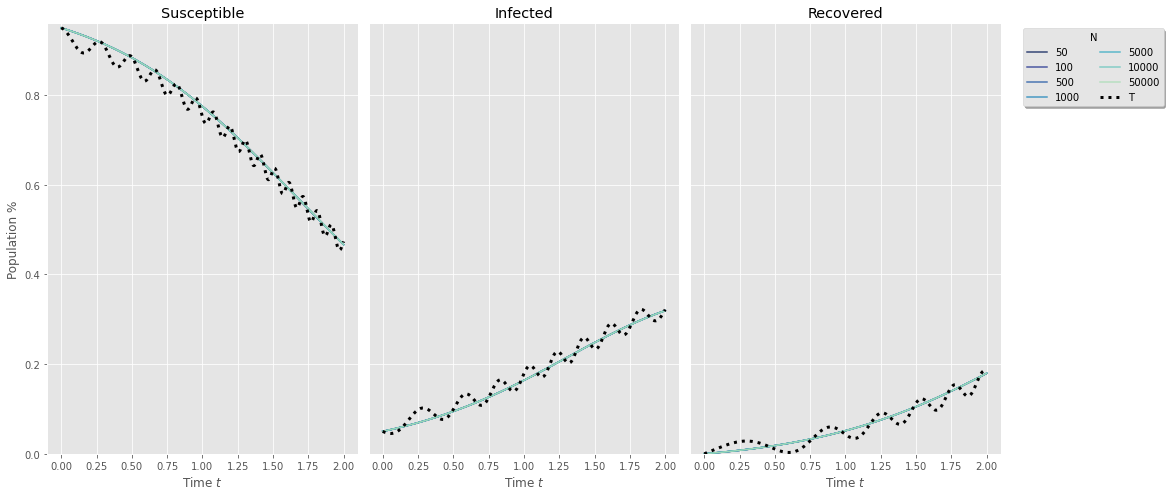

In [45]:
# Multiplot
fig, ax = plt.subplots(1, 3, figsize=(16, 7))
ax[1].set_yticklabels([]);
ax[2].set_yticklabels([]);
for tick in ax[1].yaxis.get_major_ticks():
    tick.tick1line.set_visible(False)
for tick in ax[2].yaxis.get_major_ticks():
    tick.tick1line.set_visible(False)
    '''tick.tick2line.set_visible(False)
    tick.label1.set_visible(False)
    tick.label2.set_visible(False)'''

k = colours_GD.shape[0] - 1
for N, ρ in States.items():
    Tₑ = concatenate([[0],0.5*(chebpts1(N-2)+1) * T,[T]])
    
    # Susceptible
    ax[0].plot(Tₑ, ρ[0]/n, color = colours_GD[k], alpha = 0.8, label = '{0}'.format(N))
    
    # Infected
    ax[1].plot(Tₑ, ρ[1]/n, color = colours_GD[k], alpha = 0.8, label = '{0}'.format(N))
    
    # Recovered
    ax[2].plot(Tₑ, ρ[2]/n, color = colours_GD[k], alpha = 0.8, label = '{0}'.format(N))
    
    k -= 1
    
# Add target
ax[0].plot(Tₑ, ρ̂[0]/n, ':', c='black', linewidth=3, label = 'T')
ax[1].plot(Tₑ, ρ̂[1]/n, ':', c='black', linewidth=3, label = 'T')
ax[2].plot(Tₑ, ρ̂[2]/n, ':', c='black', linewidth=3, label = 'T')

ax[0].set_ylim([0.0, (Sₒ+2)/n]);    ax[0].set_xlabel(r'Time $t$');    ax[0].set_title(r'Susceptible')
ax[1].set_ylim([0.0, (Sₒ+2)/n]);    ax[1].set_xlabel(r'Time $t$');    ax[1].set_title(r'Infected')
ax[2].set_ylim([0.0, (Sₒ+2)/n]);    ax[2].set_xlabel(r'Time $t$');    ax[2].set_title(r'Recovered')

ax[0].set_ylabel('Population %')

plt.legend(bbox_to_anchor=(1.54, 1), loc="upper right", shadow=True, ncol=2, title='N')
fig.tight_layout()
plt.savefig('Outputs/Grid – States – BFGS.pdf', bbox_inches='tight', pad_inches=0)

[]

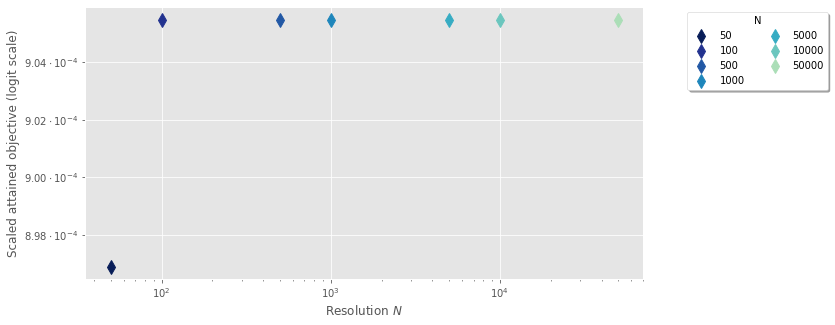

In [46]:
# Plot objective against N
plt.figure(figsize=(10,5))

k = colours_GD.shape[0] - 1
for N, fᵥ in Stats['obj'].iteritems():
    
    # Susceptible
    plt.plot(N, fᵥ, color = colours_GD[k], #markeredgecolor = "xkcd:robin's egg blue",
             alpha=1, marker='d', linestyle = '', markersize=10, 
             label = '{0}'.format(N))
    
    k -= 1
    
    
plt.xscale('log')
plt.yscale('logit')
plt.legend(bbox_to_anchor=(1.34, 1), loc="upper right", shadow=True, ncol=2, facecolor='w', title='N')

plt.xlabel(r'Resolution $N$');    plt.ylabel('Scaled attained objective (logit scale)')
plt.plot()

---

[]

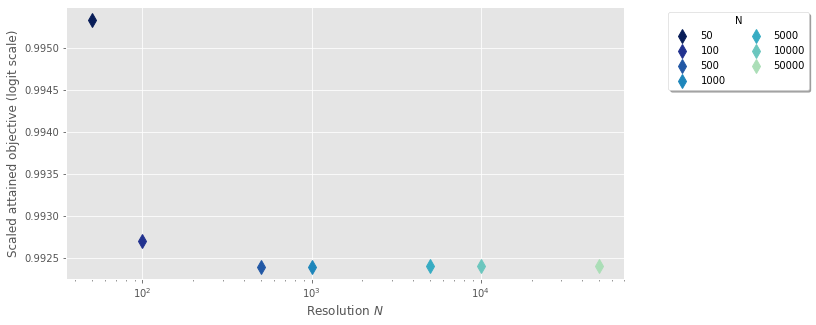

In [47]:
# Plot terminal difference against N
plt.figure(figsize=(10,5))

k = colours_GD.shape[0] - 1
for N, fᵥ in Stats['Ter'].iteritems():
    
    # Susceptible
    plt.plot(N, fᵥ, color = colours_GD[k], #markeredgecolor = "xkcd:robin's egg blue",
             alpha=1, marker='d', linestyle = '', markersize=10, 
             label = '{0}'.format(N))
    
    k -= 1
    
    
plt.xscale('log')
#plt.yscale('logit')
plt.legend(bbox_to_anchor=(1.34, 1), loc="upper right", shadow=True, ncol=2, facecolor='w', title='N')

plt.xlabel(r'Resolution $N$');    plt.ylabel('Scaled attained objective (logit scale)')
plt.plot()

Compute finer mesh:

In [86]:
Tₑ = concatenate([[0],0.5*(chebpts1(500-2)+1) * T,[T]])
# Setup target
ρ̂  = ρ̄(Tₑ)           # Sample target
dρ̂ = dρ̄(Tₑ)          # Sample derivative of target (just for resolution of interporlator)
ρ̄ₙ = CubicHermiteSpline(Tₑ, ρ̂, dρ̂, axis=-1)        # Create interpolator for the sampled data

In [87]:
# Finer evaluations
nβ, nγ = 151, 151
Misfit, Reprod = zeros([2, nβ, nγ])
β_axis = linspace(0.0,1.0,nβ)
γ_axis = linspace(0.02,1.0,nγ)
for (i,β) in enumerate(β_axis):
    for (j,γ) in enumerate(γ_axis):
        Misfit[i,j] = obj_eval_a(asarray([β,γ])).item()
        Reprod[i,j] = n * β / (γ + m)
i_0 = unravel_index(argmin(Misfit),  Misfit.shape)                     # finer mesh
M_0, β_0, γ_0 = Misfit[i_0],    β_axis[i_0[0]],    γ_axis[i_0[1]]

In [88]:
print('Smallest objective found in the mesh: {0};'.format(M_0),'(β,γ):',β_axis[i_0[0]],γ_axis[i_0[1]])

Smallest objective found in the mesh: 0.036229959328001146; (β,γ): 0.013333333333333334 0.9803999999999999


Plot of objective evaluations for f(α)/n² over finer grid


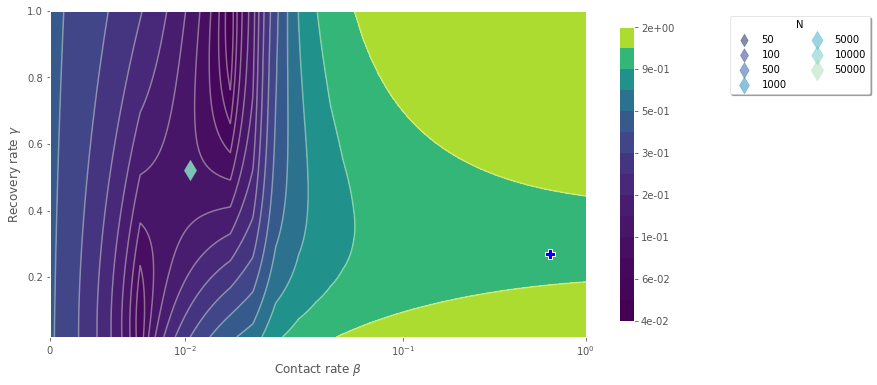

In [89]:
# Contour plot
print('Plot of objective evaluations for f(α)/n² over finer grid')

X_c, Y_c = meshgrid(β_axis, γ_axis, indexing='ij')
ℓ = linspace((Misfit).min(),(Misfit).max(),15)
ℓ = np.logspace( np.log( Misfit.min() ), np.log( Misfit.max() ), num=15, endpoint=True, base=np.e)

#fig, ax = plt.subplots(ncols=1, figsize=(50, 20))
fig, ax = plt.subplots(ncols=1, figsize=(12, 6))
cp = ax.contourf(X_c, Y_c, Misfit, ℓ)
ax.contour(cp, colors='#FFFFE6', alpha= 0.4)                                  # Contour plot
fig.colorbar(cp, shrink=0.9, format='%.0e')


# Starting point
plt.plot( rng(0).uniform(0,1,2)[0], rng(0).uniform(0,1,2)[1], 
         markersize=10, marker='P', color='white', markerfacecolor='b' )

# Approximate minimisers
k_row = colours_GD.shape[0] - 1
for row in Stats.iterrows():
    N = row[0]
    
    scatter = plt.scatter(row[1]['β'], row[1]['γ'], color = colours_GD[k_row],
         alpha = 0.5, marker='d', s = 20*np.log(N), label = '{0}'.format(N))

    k_row -= 1


ax.set_xlabel(r'Contact rate $\beta$');    ax.set_ylabel(r'Recovery rate $\gamma$')
#plt.title(r'Plot of objective evaluations for ${f(\alpha)}/{n^2}$ over finer grid')
#plt.xscale('log')
#plt.xscale('symlog', linthresh = 3e-1)
plt.xscale('symlog', linthresh = 1.5e-2)
plt.legend(bbox_to_anchor=(1.54, 1), loc="upper right", shadow=True, ncol=2, facecolor='w', title='N')
plt.show()
#fig.savefig('Outputs/Regularisation – Contour[a].pdf', bbox_inches='tight', pad_inches=0)

Compute finer mesh around minimisers:

In [66]:
# Finer evaluations
nβ, nγ = 151, 151
Misfit, Reprod = zeros([2, nβ, nγ])
#β_axis = linspace(0.005,0.02,nβ)
#γ_axis = linspace(0.2,0.8,nγ)
β_axis = linspace(0.0,0.02,nβ)
γ_axis = linspace(0.0,1.0,nγ)
for (i,β) in enumerate(β_axis):
    for (j,γ) in enumerate(γ_axis):
        Misfit[i,j] = obj_eval_a(asarray([β,γ])).item()
        Reprod[i,j] = n * β / (γ + m)
i_0 = unravel_index(argmin(Misfit),  Misfit.shape)                     # finer mesh
M_0, β_0, γ_0 = Misfit[i_0],    β_axis[i_0[0]],    γ_axis[i_0[1]]

In [167]:
print('Smallest objective found in the mesh: {0};'.format(M_0),'(β,γ):',β_axis[i_0[0]],γ_axis[i_0[1]])

Smallest objective found in the mesh: 0.0009160903479199863; (β,γ): 0.010266666666666667 0.5133333333333334


Plot of objective evaluations for f(α)/n² over finer grid


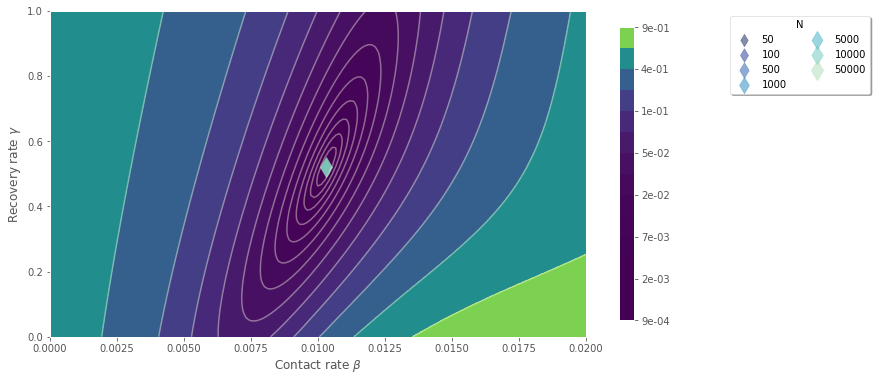

In [168]:
# Contour plot
print('Plot of objective evaluations for f(α)/n² over finer grid')

X_c, Y_c = meshgrid(β_axis, γ_axis, indexing='ij')
ℓ = linspace((Misfit).min(),(Misfit).max(),15)
ℓ = np.logspace( np.log( Misfit.min() ), np.log( Misfit.max() ), num=15, endpoint=True, base=np.e)

#fig, ax = plt.subplots(ncols=1, figsize=(50, 20))
fig, ax = plt.subplots(ncols=1, figsize=(12, 6))
cp = ax.contourf(X_c, Y_c, Misfit, ℓ)
ax.contour(cp, colors='#FFFFE6', alpha= 0.4)                                  # Contour plot
fig.colorbar(cp, shrink=0.9, format='%.0e')


# Approximate minimisers
k_row = colours_GD.shape[0] - 1
for row in Stats.iterrows():
    N = row[0]
    
    scatter = plt.scatter(row[1]['β'], row[1]['γ'], color = colours_GD[k_row],
         alpha = 0.5, marker='d', s = 20*np.log(N), label = '{0}'.format(N))

    k_row -= 1


ax.set_xlabel(r'Contact rate $\beta$');    ax.set_ylabel(r'Recovery rate $\gamma$')
#plt.title(r'Plot of objective evaluations for ${f(\alpha)}/{n^2}$ over finer grid')
#plt.xscale('log')
#plt.xscale('symlog', linthresh = 3e-1)
#plt.xscale('symlog', linthresh = 1.5e-2)
plt.legend(bbox_to_anchor=(1.54, 1), loc="upper right", shadow=True, ncol=2, facecolor='w', title='N')
plt.show()
#fig.savefig('Outputs/Regularisation – Contour[a].pdf', bbox_inches='tight', pad_inches=0)

---

Compute a fine gradient:

In [45]:
from scipy.interpolate import interp1d
from scipy.integrate import romberg

In [68]:
def obj_eval_der(α):                  # ** Eval f' ** #
    global ρ, q, df
    '''
        Evaluate state, compute adjoint, and return objective and derivative
    '''
    scaling = True
    
    # Compute state α
    ρ_sol = solve_ivp(SIR, [0, T], [Sₒ, Iₒ, Rₒ], args=α, t_eval = Tₑ, 
                      dense_output=True, vectorized=True)
    if ρ_sol['success'] != True:    print('Should re-evaluate for', ω)
    ρ = ρ_sol.y
    
    '''# Define integrand
    def f_integrand(t): return ((ρ̄(t) - ρₜ(t))**2).sum()
    
    
    # Integrate and add parameter norm
    f  = romberg(f_integrand, 0.0, T, show = False, vec_func=True, divmax = 20)
    f += (θ * (α**2).sum())
    f *= 0.5
    f /= (n**2) if scaling else 1.0'''
    
    
    # Create an abstract interpolator for state
    ρₜ = CubicHermiteSpline(Tₑ, ρ, asarray(SIR(0,ρ,α[0],α[1])), axis=-1)
    
    # Compute adjoint
    qₒ = ϑᵀᵉʳ*(ρ[:,-1] - ρ̂[:,-1])       # Terminal condition of adjoint
    q_sol = solve_ivp(Adjoint, [T,0], qₒ, args=(α[0], α[1], ρₜ, ρ̄ₙ), t_eval = Tₑ[::-1], 
                      dense_output=True, vectorized=True)
    q = q_sol.y[:,::-1]
    
    # Interpolate adjoint for handy evaluation of adjoint equation
    qᵢ = interp1d(Tₑ, q, axis=-1)
    
    # Evaluate dq/dt
    dq = np.zeros_like(ρ)
    for i in range(Tₑ.size):
        t = Tₑ[i]
        dq[:,i] = Adjoint(t, qᵢ(t), α[0], α[1], ρₜ, ρ̄ₙ)
        
    # Create a higher order accuracy interpolator for adjoint
    qₕ = CubicHermiteSpline(Tₑ, q, dq, axis=-1)
    
    # Define integrands
    def Df_integrand_β(t):
        ρ = ρₜ(t)
        q = qₕ(t)
        return ρ[0]*ρ[1] * (q[1]-q[0])
    def Df_integrand_γ(t):
        ρ = ρₜ(t)
        q = qₕ(t)
        return ρ[1] * (q[2]-q[1])

    # Compute derivative
    dβ = romberg(Df_integrand_β, 0.0, T, show = False, vec_func=True, divmax = 20)
    dγ = romberg(Df_integrand_γ, 0.0, T, show = False, vec_func=True, divmax = 20)
    
    df = asarray([dβ, dγ]).ravel()
    df += (θ * α)
    df /= (n**2) if scaling else 1.0
    
    return df

In [69]:
dfₐ, dfₛ = obj_eval_der(asarray([0.05,0.95])),  obj_eval_d(asarray([0.05,0.95]))[1]

In [70]:
print('Derivative with adaptive integration:', dfₐ)
print('Derivative with Simpsons quadrature:',  dfₛ)
print('Absolute error:',  norm(dfₐ-dfₛ, np.inf) )
print('Relative error:',  norm(dfₐ-dfₛ, np.inf)/norm(dfₐ, np.inf) )

Derivative with adaptive integration: [9.68303092 0.52755915]
Derivative with Simpsons quadrature: [9.68303092 0.52755915]
Absolute error: 0.0
Relative error: 0.0


In [71]:
# Finer evaluations
nβ, nγ = 151, 151
Misfit_dβ, Misfit_dγ = zeros([2,nβ, nγ])
β_axis = linspace(0.0,1.0,nβ)
γ_axis = linspace(0.02,1.0,nγ)
for (i,β) in enumerate(β_axis):
    if i % 10 == 0:
        print(i,β)
    for (j,γ) in enumerate(γ_axis):
        df = obj_eval_der(asarray([β,γ]))
        Misfit_dβ[i,j] = df[0]
        Misfit_dγ[i,j] = df[1]
#i_0 = unravel_index(argmin(Misfit),  Misfit.shape)                     # finer mesh
#M_0, β_0, γ_0 = Misfit[i_0],    β_axis[i_0[0]],    γ_axis[i_0[1]]

0 0.0
10 0.06666666666666667
20 0.13333333333333333
30 0.2
40 0.26666666666666666
50 0.33333333333333337
60 0.4
70 0.4666666666666667
80 0.5333333333333333
90 0.6000000000000001
100 0.6666666666666667
110 0.7333333333333334
120 0.8
130 0.8666666666666667
140 0.9333333333333333
150 1.0


Plot of derivative evaluations for ∂ᵦf(α)/n² over finer grid


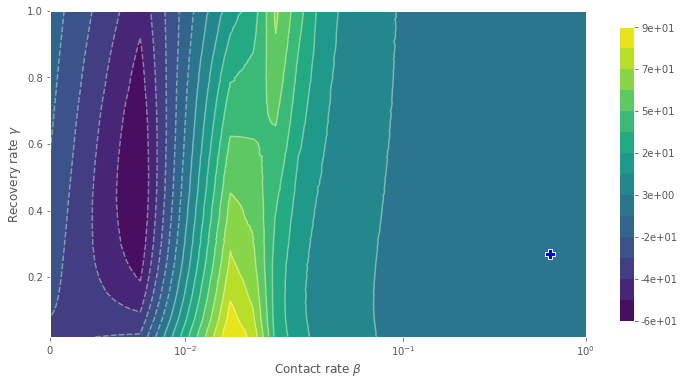

In [72]:
# Contour plot
print('Plot of derivative evaluations for ∂ᵦf(α)/n² over finer grid')

X_c, Y_c = meshgrid(β_axis, γ_axis, indexing='ij')
ℓ = linspace((Misfit_dβ).min(),(Misfit_dβ).max(),15)
#ℓ = np.logspace( np.log( Misfit.min() ), np.log( Misfit.max() ), num=15, endpoint=True, base=np.e)

#fig, ax = plt.subplots(ncols=1, figsize=(50, 20))
fig, ax = plt.subplots(ncols=1, figsize=(12, 6))
cp = ax.contourf(X_c, Y_c, Misfit_dβ, ℓ)
ax.contour(cp, colors='#FFFFE6', alpha= 0.4)                                  # Contour plot
fig.colorbar(cp, shrink=0.9, format='%.0e')


# Starting point
plt.plot( rng(0).uniform(0,1,2)[0], rng(0).uniform(0,1,2)[1], 
         markersize=10, marker='P', color='white', markerfacecolor='b' )



ax.set_xlabel(r'Contact rate $\beta$');    ax.set_ylabel(r'Recovery rate $\gamma$')
#plt.title(r'Plot of objective evaluations for ${f(\alpha)}/{n^2}$ over finer grid')
#plt.xscale('log')
#plt.xscale('symlog', linthresh = 3e-1)
plt.xscale('symlog', linthresh = 1.5e-2)
#plt.legend(bbox_to_anchor=(1.54, 1), loc="upper right", shadow=True, ncol=2, facecolor='w', title='θ')
plt.show()
#fig.savefig('Outputs/Regularisation – Contour[a].pdf', bbox_inches='tight', pad_inches=0)

Plot of derivative evaluations for ∂ᵧf(α)/n² over finer grid


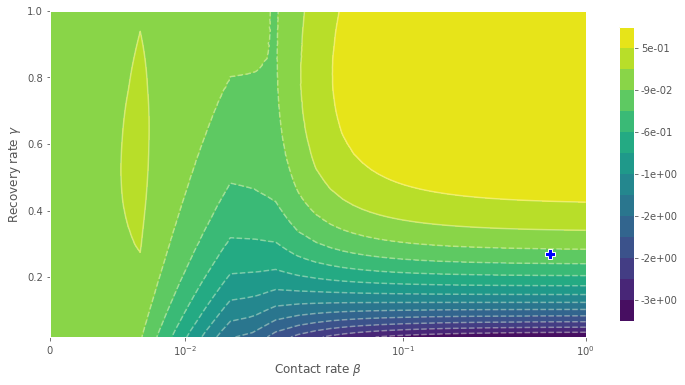

In [73]:
# Contour plot
print('Plot of derivative evaluations for ∂ᵧf(α)/n² over finer grid')

X_c, Y_c = meshgrid(β_axis, γ_axis, indexing='ij')
ℓ = linspace((Misfit_dγ).min(),(Misfit_dγ).max(),15)
#ℓ = np.logspace( np.log( Misfit.min() ), np.log( Misfit.max() ), num=15, endpoint=True, base=np.e)

#fig, ax = plt.subplots(ncols=1, figsize=(50, 20))
fig, ax = plt.subplots(ncols=1, figsize=(12, 6))
cp = ax.contourf(X_c, Y_c, Misfit_dγ, ℓ)
ax.contour(cp, colors='#FFFFE6', alpha= 0.4)                                  # Contour plot
fig.colorbar(cp, shrink=0.9, format='%.0e')


# Starting point
plt.plot( rng(0).uniform(0,1,2)[0], rng(0).uniform(0,1,2)[1], 
         markersize=10, marker='P', color='white', markerfacecolor='b' )



ax.set_xlabel(r'Contact rate $\beta$');    ax.set_ylabel(r'Recovery rate $\gamma$')
#plt.title(r'Plot of objective evaluations for ${f(\alpha)}/{n^2}$ over finer grid')
#plt.xscale('log')
#plt.xscale('symlog', linthresh = 3e-1)
plt.xscale('symlog', linthresh = 1.5e-2)
#plt.legend(bbox_to_anchor=(1.54, 1), loc="upper right", shadow=True, ncol=2, facecolor='w', title='θ')
plt.show()
#fig.savefig('Outputs/Regularisation – Contour[a].pdf', bbox_inches='tight', pad_inches=0)

In [74]:
Misfit_d = (Misfit_dβ**2 + Misfit_dγ**2)**0.5

Plot of derivative evaluations for ∂ᵧf(α)/n² over finer grid


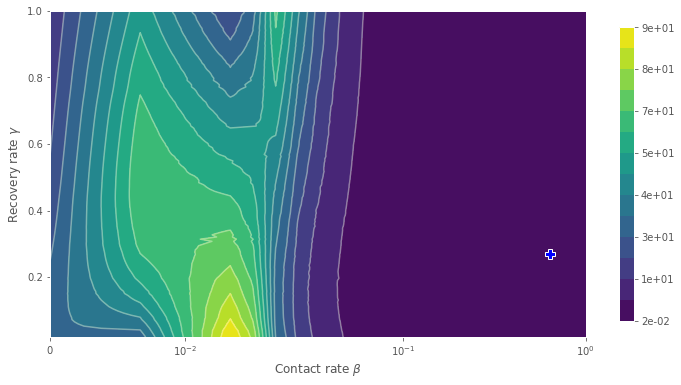

In [75]:
# Contour plot
print('Plot of derivative evaluations for ∂ᵧf(α)/n² over finer grid')

X_c, Y_c = meshgrid(β_axis, γ_axis, indexing='ij')
ℓ = linspace((Misfit_d).min(),(Misfit_d).max(),15)
#ℓ = np.logspace( np.log( Misfit.min() ), np.log( Misfit.max() ), num=15, endpoint=True, base=np.e)

#fig, ax = plt.subplots(ncols=1, figsize=(50, 20))
fig, ax = plt.subplots(ncols=1, figsize=(12, 6))
cp = ax.contourf(X_c, Y_c, Misfit_d, ℓ)
ax.contour(cp, colors='#FFFFE6', alpha= 0.4)                                  # Contour plot
fig.colorbar(cp, shrink=0.9, format='%.0e')


# Starting point
plt.plot( rng(0).uniform(0,1,2)[0], rng(0).uniform(0,1,2)[1], 
         markersize=10, marker='P', color='white', markerfacecolor='b' )



ax.set_xlabel(r'Contact rate $\beta$');    ax.set_ylabel(r'Recovery rate $\gamma$')
#plt.title(r'Plot of objective evaluations for ${f(\alpha)}/{n^2}$ over finer grid')
#plt.xscale('log')
#plt.xscale('symlog', linthresh = 3e-1)
plt.xscale('symlog', linthresh = 1.5e-2)
#plt.legend(bbox_to_anchor=(1.54, 1), loc="upper right", shadow=True, ncol=2, facecolor='w', title='θ')
plt.show()
#fig.savefig('Outputs/Regularisation – Contour[a].pdf', bbox_inches='tight', pad_inches=0)

Get closer to minimisers:

In [76]:
# Finer evaluations
nβ, nγ = 151, 151
Misfit_dβ, Misfit_dγ = zeros([2,nβ, nγ])
β_axis = linspace(0.0,0.02,nβ)
γ_axis = linspace(0.0,1.0,nγ)
for (i,β) in enumerate(β_axis):
    if i % 10 == 0:
        print(i,β)
    for (j,γ) in enumerate(γ_axis):
        df = obj_eval_der(asarray([β,γ]))
        Misfit_dβ[i,j] = df[0]
        Misfit_dγ[i,j] = df[1]
#i_0 = unravel_index(argmin(Misfit),  Misfit.shape)                     # finer mesh
#M_0, β_0, γ_0 = Misfit[i_0],    β_axis[i_0[0]],    γ_axis[i_0[1]]

0 0.0
10 0.0013333333333333335
20 0.002666666666666667
30 0.004
40 0.005333333333333334
50 0.006666666666666667
60 0.008
70 0.009333333333333334
80 0.010666666666666668
90 0.012
100 0.013333333333333334
110 0.014666666666666668
120 0.016
130 0.017333333333333333
140 0.018666666666666668
150 0.02


In [77]:
Misfit_d = (Misfit_dβ**2 + Misfit_dγ**2)**0.5

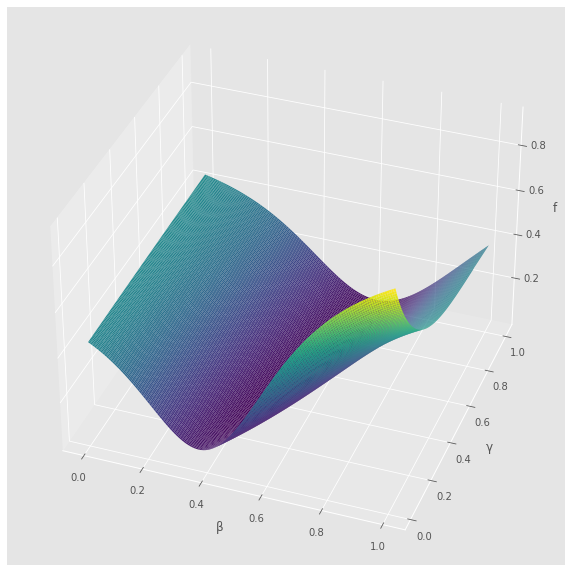

In [78]:
fig = plt.figure(figsize=(10, 15))
ax = plt.axes(projection='3d')

X = X_c.copy()
#X = np.log10(X)
ax.plot_surface(X, Y_c, Misfit, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_xlabel('β')
ax.set_ylabel('γ')
ax.set_zlabel('f');
ax.view_init(35,-70)

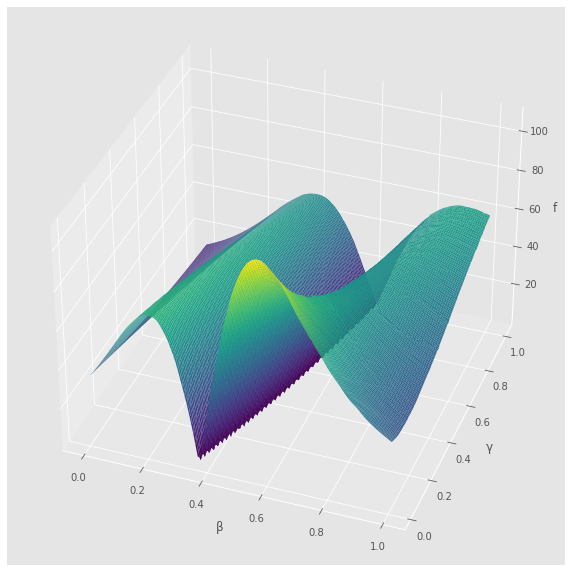

In [79]:
fig = plt.figure(figsize=(10, 15))
ax = plt.axes(projection='3d')

X = X_c.copy()
#X = np.log10(X)
ax.plot_surface(X, Y_c, Misfit_d, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_xlabel('β')
ax.set_ylabel('γ')
ax.set_zlabel('f');
ax.view_init(35,-70)

Plot of derivative evaluations for ∂ᵧf(α)/n² over finer grid


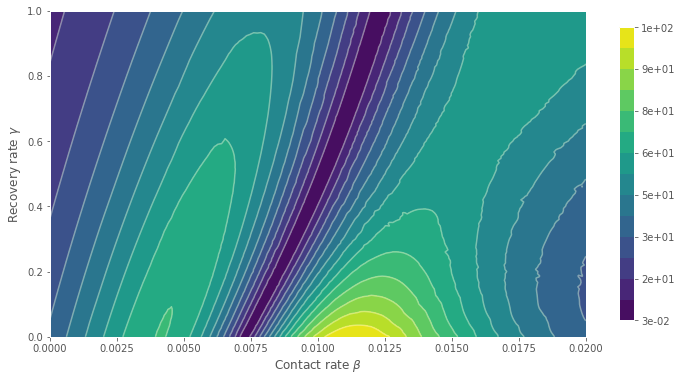

In [80]:
# Contour plot
print('Plot of derivative evaluations for ∂ᵧf(α)/n² over finer grid')

X_c, Y_c = meshgrid(β_axis, γ_axis, indexing='ij')
ℓ = linspace((Misfit_d).min(),(Misfit_d).max(),15)
#ℓ = np.logspace( np.log( Misfit.min() ), np.log( Misfit.max() ), num=15, endpoint=True, base=np.e)

#fig, ax = plt.subplots(ncols=1, figsize=(50, 20))
fig, ax = plt.subplots(ncols=1, figsize=(12, 6))
cp = ax.contourf(X_c, Y_c, Misfit_d, ℓ)
ax.contour(cp, colors='#FFFFE6', alpha= 0.4)                                  # Contour plot
fig.colorbar(cp, shrink=0.9, format='%.0e')




ax.set_xlabel(r'Contact rate $\beta$');    ax.set_ylabel(r'Recovery rate $\gamma$')
#plt.title(r'Plot of objective evaluations for ${f(\alpha)}/{n^2}$ over finer grid')
#plt.xscale('log')
#plt.xscale('symlog', linthresh = 3e-1)
#plt.xscale('symlog', linthresh = 1.5e-2)
#plt.legend(bbox_to_anchor=(1.54, 1), loc="upper right", shadow=True, ncol=2, facecolor='w', title='θ')
plt.show()
#fig.savefig('Outputs/Regularisation – Contour[a].pdf', bbox_inches='tight', pad_inches=0)

---

In [49]:
Stats

,it,obj,time,β,γ,df_β,df_γ,t_k,Ter,norms-ℓ_1,norms-ℓ_2,norms-max,norms-min
50,60,0.0008969149499817409,3.848850,0.010308,0.520410,0.009769,-0.000333,0.5,0.995332,0.005051,0.006911,0.009769,0.000333
100,69,0.0009054824489446784,3.390466,0.010313,0.521204,0.033052,-0.000173,0.5,0.992704,0.016612,0.023372,0.033052,0.000173
500,49,0.0009054815508661847,2.721317,0.010313,0.521224,0.033356,-0.000166,0.5,0.992396,0.016761,0.023587,0.033356,0.000166
1000,157,0.0009054815538797387,3.689146,0.010313,0.521224,0.033354,-0.000166,0.5,0.992398,0.016760,0.023585,0.033354,0.000166
5000,66,0.0009054815750266751,3.877591,0.010313,0.521224,0.033363,-0.000166,0.5,0.992399,0.016764,0.023591,0.033363,0.000166
10000,69,0.0009054815395007777,4.404882,0.010313,0.521222,0.033345,-0.000166,0.5,0.992403,0.016755,0.023579,0.033345,0.000166
50000,61,0.0009054815415909558,8.301566,0.010313,0.521223,0.033345,-0.000166,0.5,0.992402,0.016756,0.023579,0.033345,0.000166


In [50]:
Stats.to_pickle('Outputs/Grid – LMBFGS - Final.pkl') # To read back use pd.read_pickle(file_name)

---

# Optimisation with adaptive step
Here we will optimise using an adaptive step integrator to compute the objective function and its derivative:

In [42]:
def obj_eval(α):                  # ** Eval f and f' ** #
    global ρ, q, df,  ρ̂, ρ̄ₙ
    '''
        Evaluate state, compute adjoint, and return objective and derivative
    '''
    scaling = True
    
    # Compute state α
    ρ_sol = solve_ivp(SIR, [0, T], [Sₒ, Iₒ, Rₒ], args=α, t_eval = Tₑ, 
                      dense_output=True, vectorized=True)
    if ρ_sol['success'] != True:    print('Should re-evaluate for', α)
    ρ = ρ_sol.y
    
    
    # Create an abstract interpolator for state
    ρₜ = CubicHermiteSpline(Tₑ, ρ, asarray(SIR(0,ρ,α[0],α[1])), axis=-1)
    
    # Define integrand
    def f_integrand(t): return ((ρ̄ₙ(t) - ρₜ(t))**2).sum()
    
    # Integrate and add parameter norm
    f  = romberg(f_integrand, 0.0, T, show = False, vec_func=True, divmax = 30)
    f += (θ * (α**2).sum())
    f += ϑᵀᵉʳ * ((ρ̂[:,-1] - ρ[:,-1])**2).sum()
    f *= 0.5
    f /= (n**2) if scaling else 1.0
    
    # Compute adjoint
    qₒ = ϑᵀᵉʳ*(ρ[:,-1] - ρ̂[:,-1])       # Terminal condition of adjoint
    q_sol = solve_ivp(Adjoint, [T,0], qₒ, args=(α[0], α[1], ρₜ, ρ̄ₙ), t_eval = Tₑ[::-1], 
                      dense_output=True, vectorized=True)
    q = q_sol.y[:,::-1]
    
    # Interpolate adjoint for handy evaluation of adjoint equation
    qᵢ = interp1d(Tₑ, q, axis=-1)
    
    # Evaluate dq/dt
    dq = np.zeros_like(ρ)
    for i in range(Tₑ.size):
        t = Tₑ[i]
        dq[:,i] = Adjoint(t, qᵢ(t), α[0], α[1], ρₜ, ρ̄ₙ)
        
    # Create a higher order accuracy interpolator for adjoint
    qₕ = CubicHermiteSpline(Tₑ, q, dq, axis=-1)
    
    # Define integrands
    def Df_integrand_β(t):
        ρ = ρₜ(t)
        q = qₕ(t)
        return ρ[0]*ρ[1] * (q[1]-q[0])
    def Df_integrand_γ(t):
        ρ = ρₜ(t)
        q = qₕ(t)
        return ρ[1] * (q[2]-q[1])

    # Compute derivative
    dβ = romberg(Df_integrand_β, 0.0, T, show = False, vec_func=True, divmax = 30)
    dγ = romberg(Df_integrand_γ, 0.0, T, show = False, vec_func=True, divmax = 30)
    
    df = asarray([dβ, dγ]).ravel()
    df += (θ * α)
    df /= (n**2) if scaling else 1.0
    
    return asarray(f), df
def obj_eval_a(α):                # ** Eval just f ** #
    global ρ, ρ̂
    '''
        Evaluate state, compute adjoint, and return objective and derivative
    '''
    scaling = True
    
    # Compute state α
    ρ_sol = solve_ivp(SIR, [0, T], [Sₒ, Iₒ, Rₒ], args=α, t_eval = Tₑ, 
                      dense_output=True, vectorized=True)
    if ρ_sol['success'] != True:    print('Should re-evaluate for', α)
    ρ = ρ_sol.y
    
    
    # Create an abstract interpolator for state
    ρₜ = CubicHermiteSpline(Tₑ, ρ, asarray(SIR(0,ρ,α[0],α[1])), axis=-1)
    
    # Define integrand
    def f_integrand(t): return ((ρ̄ₙ(t) - ρₜ(t))**2).sum()
    
    # Integrate and add parameter norm
    f  = romberg(f_integrand, 0.0, T, show = False, vec_func=True, divmax = 20)
    f += (θ * (α**2).sum())
    f += ϑᵀᵉʳ * ((ρ̂[:,-1] - ρ[:,-1])**2).sum()
    f *= 0.5
    f /= (n**2) if scaling else 1.0
    
    return asarray(f)
def obj_eval_b(α):                # ** Does not affect global variable ρ ** #
    global ρ̂
    '''
        Evaluate state, compute adjoint, and return objective and derivative
    '''
    scaling = True
    
    # Compute state α
    ρ_sol = solve_ivp(SIR, [0, T], [Sₒ, Iₒ, Rₒ], args=α, t_eval = Tₑ, 
                      dense_output=True, vectorized=True)
    if ρ_sol['success'] != True:    print('Should re-evaluate for', α)
    ρₐ = ρ_sol.y
    
    
    # Create an abstract interpolator for state
    ρₜ = CubicHermiteSpline(Tₑ, ρₐ, asarray(SIR(0,ρₐ,α[0],α[1])), axis=-1)
    
    # Define integrand
    def f_integrand(t): return ((ρ̄ₙ(t) - ρₜ(t))**2).sum()
    
    # Integrate and add parameter norm
    f  = romberg(f_integrand, 0.0, T, show = False, vec_func=True, divmax = 20)
    f += (θ * (α**2).sum())
    f += ϑᵀᵉʳ * ((ρ̂[:,-1] - ρₐ[:,-1])**2).sum()
    f *= 0.5
    f /= (n**2) if scaling else 1.0
    
    return asarray(f)
def obj_eval_d(α):                # ** Does not affect global variables ρ, q, df ** #
    global ρ̂, ρ̄ₙ
    '''
        Evaluate state, compute adjoint, and return objective and derivative
    '''
    scaling = True
    
    # Compute state α
    ρ_sol = solve_ivp(SIR, [0, T], [Sₒ, Iₒ, Rₒ], args=α, t_eval = Tₑ, 
                      dense_output=True, vectorized=True)
    if ρ_sol['success'] != True:    print('Should re-evaluate for', α)
    ρₐ = ρ_sol.y
    
    
    # Create an abstract interpolator for state
    ρₜ = CubicHermiteSpline(Tₑ, ρₐ, asarray(SIR(0,ρₐ,α[0],α[1])), axis=-1)
    
    # Define integrand
    def f_integrand(t): return ((ρ̄ₙ(t) - ρₜ(t))**2).sum()
    
    # Integrate and add parameter norm
    f  = romberg(f_integrand, 0.0, T, show = False, vec_func=True, divmax = 30)
    f += (θ * (α**2).sum())
    f += ϑᵀᵉʳ * ((ρ̂[:,-1] - ρₐ[:,-1])**2).sum()
    f *= 0.5
    f /= (n**2) if scaling else 1.0
    
    # Compute adjoint
    qₒ = ϑᵀᵉʳ*(ρₐ[:,-1] - ρ̂[:,-1])       # Terminal condition of adjoint
    q_sol = solve_ivp(Adjoint, [T,0], qₒ, args=(α[0], α[1], ρₜ, ρ̄ₙ), t_eval = Tₑ[::-1], 
                      dense_output=True, vectorized=True)
    qₐ = q_sol.y[:,::-1]
    
    # Interpolate adjoint for handy evaluation of adjoint equation
    qᵢ = interp1d(Tₑ, qₐ, axis=-1)
    
    # Evaluate dq/dt
    dq = np.zeros_like(ρₐ)
    for i in range(Tₑ.size):
        t = Tₑ[i]
        dq[:,i] = Adjoint(t, qᵢ(t), α[0], α[1], ρₜ, ρ̄ₙ)
        
    # Create a higher order accuracy interpolator for adjoint
    qₕ = CubicHermiteSpline(Tₑ, qₐ, dq, axis=-1)
    
    # Define integrands
    def Df_integrand_β(t):
        ρ = ρₜ(t)
        q = qₕ(t)
        return ρ[0]*ρ[1] * (q[1]-q[0])
    def Df_integrand_γ(t):
        ρ = ρₜ(t)
        q = qₕ(t)
        return ρ[1] * (q[2]-q[1])

    # Compute derivative
    dβ = romberg(Df_integrand_β, 0.0, T, show = False, vec_func=True, divmax = 30)
    dγ = romberg(Df_integrand_γ, 0.0, T, show = False, vec_func=True, divmax = 30)
    
    df = asarray([dβ, dγ]).ravel()
    df += (θ * α)
    df /= (n**2) if scaling else 1.0
    
    return asarray(f), df

In [43]:
# Evaluation interval using Chebyshev points of the first kind
Tₑ = concatenate([[0],0.5*(chebpts1(500-2)+1) * T,[T]])
# Setup target
ρ̂  = ρ̄(Tₑ)           # Sample target
dρ̂ = dρ̄(Tₑ)          # Sample derivative of target (just for resolution of interporlator)
ρ̄ₙ = CubicHermiteSpline(Tₑ, ρ̂, dρ̂, axis=-1)        # Create interpolator for the sampled data

The effects can be measured by a simple test:

```Python
    > obj_eval(α)                             ''' Simpson's quadrature '''
    1.19132261, [ 0.03553197, -0.17681613]
    > obj_eval(α)                             ''' Adaptive quadrature '''
    1.1913226, [ 0.03553204, -0.17681612]
```

Between methods, we observe a relative error of around $10^{-8}$ in the objective and $4\times 10^{-7}$ in the gradient.

In [46]:
'''

    ********************************* AS-LM-BFGS algorithm *********************************

'''
Method = 'BFGS'


'''Reserve memory'''
cLM   = 1
S     = append([1], zeros(dim-1)).reshape(dim,1);                        Y = S.copy()
SY, O = empty([cLM,cLM], dtype=float), zeros([cLM,cLM], dtype=float)


''' Create structures to store information from iterates '''
save_iter = True            # Do we store information for every iteration?
if save_iter:
    ei_keys = ['it', 'obj', 'time', 'β', 'γ', 'df_β', 'df_γ', 't_k', 'Ter', 'norms']
    ei_norm = ['ℓ_1', 'ℓ_2', 'max', 'min']

    every_iter = {a:[] for a in ei_keys}
    every_iter['norms'] = {a:[] for a in ei_norm}


save_critical = True        # Do we store information for every "critical" iteration?
critical = 10               # An iteration is critical after some iterations
if save_critical:
    ec_keys = ['it', 'obj', 'time', '|df|_2', '|df|_max']

    every_critical = {a:[] for a in ec_keys}


''' Initial point '''
xₖ = asarray(α).copy()      # Be aware this α is different from αᵪ below


''' Algorithm parameters'''
# All parameters involved in the algorithm will have a "ᵪ" decorator added to them to avoid confusion.
''' Setting TR parameters '''
αᵪ = [0.5, 2.0]                  # TR scaling factors  0 < αᵪ[0] < 1 < αᵪ[1]
ρᵪ = [1e-5,0.75]                 # TR acceptance ratio (Success & Increase region)  0 < ρᵪ[0] < ρᵪ[1] < 1
#ρᵪ = [1e-2,0.5]
bᵪ = 1.0                         # Box upper bound
σᵪ = 0.003                       # Armijo–Goldstein parameter for linesearch  0 < σᵪ < 1 (l/2L?) [0.00025]
ηᵪ = 0.9                         # Normalisation scale for gradient directions  0 < ηᵪ < 1
δᵪ = 0.99 * 0.5                  # Ambiguity threshold for active set estimation  δᵪ < ½ (ℓ-u)  [small>linear]
cᵪ = 1.5                         # Gradient scaling factor for active set estimation  c > 0  [goes along pᵪ]
pᵪ = 0.15                        # 0 < pᵪ < 1 [comment after Lemma 9.7 in 10.1007/978-1-4757-3279-5_9] 0.15
mᵪ = 5                           # Memory size for LM
θᵪ = 1.0                         # Initial weight for basic Hessian approximation
Δᵪ = [1.0, 2.0, 1e-6, 1.0]       # TR radii: Δₖ, Δₘₐₓ, Δₘᵢₙ, Δ̂

''' Additional tolerances '''
εᵪ_LM    = 1e-4                  # Tolerance of curvature sₖᵀyₖ > ε
εᵪ_HCond = 1e-4                  # Himmeblau stopping condition for small functional values
εᵪ_Ha    = 1e-11                 # Absolute Himmeblau criteria
εᵪ_Hb    = 1e-13                  # Relative Himmeblau criteria


''' Initial iteration (xₒ, fₒ, dfₒ) '''
fₖ, dfₖ  = obj_eval(xₖ)
#print(fₖ)
Obj_Res = [];              Obj_Res.append(fₖ.tolist())
''' Initial iteration counter and maximum number of iterations '''
kᵪ      = 0;
Max_It  = 200


timed = 0.0              # Clock

''' Run algorithm for the given settings '''
for kᵪ in range(Max_It):

    # Print header of table
    if kᵪ == 0:
        print('{0:^5s}|{1:^11s}|{2:^11s}|{3:^11s}|{4:^11s}|{5:^11s}|'.format('#','β', 'γ', 'f(α)',
                                                                    'ᵣ‖∇f(α)‖2','ᵣ‖∇f(α)‖∞'), end='')
        print('{0:^5s}|{1:^5s}|{2:^8s}|{3:^11s}|{4:^11s}'.format('#Aₖ','#Iₖ','tₖ','ᵣ‖d‖2', 'Time'))

        print('–'*110)

        # Report initial iteration info
        if save_iter:
            every_iter['it'].append( kᵪ-1 )
            every_iter['obj'].append( fₖ )
            every_iter['time'].append( timed )
            every_iter['β'].append( xₖ[0] )
            every_iter['γ'].append( xₖ[1] )
            every_iter['df_β'].append( dfₖ[0] )
            every_iter['df_γ'].append( dfₖ[1] )
            every_iter['t_k'].append( 0.0 )
            every_iter['Ter'].append( norm( ρ̂[:,-1] - ρ[:,-1] )/(3**0.5) )
            # Store norms of gradient
            every_iter['norms']['ℓ_2'].append( norm(dfₖ)/(2**0.5) )
            every_iter['norms']['ℓ_1'].append( norm(dfₖ,1)/2 )
            every_iter['norms']['max'].append( norm(dfₖ,np.inf) )
            every_iter['norms']['min'].append( abs(dfₖ).min() )
        if kᵪ % critical == 0:
            every_critical['it'].append( kᵪ-1 )
            every_critical['obj'].append( fₖ )
            every_critical['time'].append( timed )
            every_critical['|df|_2'].append( norm(dfₖ)/(2**0.5) )
            every_critical['|df|_max'].append( norm(dfₖ,np.inf) )

        print('{0:^5d}|{1:^11.3e}|{2:^11.3e}|{3:^11.3e}|{4:^11.3e}|{5:^11.3e}|'.format(kᵪ-1, xₖ[0], xₖ[1], fₖ,
                                                            norm(dfₖ)/(dim**0.5), norm(dfₖ, np.inf)) )

    # *************** #
    # Stationarity test
    if np.all(dfₖ[xₖ == 0.0] >= 0.0) & np.all(dfₖ[xₖ == 1] <= 0.0) & allclose(dfₖ[logical_and(xₖ>0.0, xₖ<1)], 0.0):
        print('Optimality reached.')
        break

    it_time = time.time()                                # Clock

    # *************** #
    # 1. TR radii update
    Δᵪ[0]  = min(Δᵪ[1], max(Δᵪ[2], Δᵪ[0]))               # Δₖ
    Δᵪ[-1] = Δᵪ[0]                                       # Δ̂

    # *************** #
    # 2. Active-set estimation: Determine the index sets Aₖ and Iₖ
    ξᵪ = min(δᵪ, cᵪ * norm(dfₖ) ** pᵪ )                  # Estimate of inactive region (12)
    Iₖ = where( (xₖ > ξᵪ) & (xₖ < bᵪ-ξᵪ) )[0]             # Inactive set (13)
    Aₖ = where( (xₖ <= ξᵪ) + (xₖ >= bᵪ-ξᵪ) )[0]            # Active set (13)

    # *************** #
    # 3. Trust-Region Subproblem

    # ––––––––– #
    # Limited memory matrix
    if Method == 'BFGS':
                 MI, MH, W, WH = LBFGS(S,Y,SY, θᵪ)       # BFGS
    else:        MI, MH, W, WH = LSR1(S,Y,SY, θᵪ)        # SR1
    #
    B_eval, BA_eval, BAT_eval, H_eval, HA_eval, HAT_eval = Limited()

    # ––––––––– #
    # Gradient scaling
    γᵪ  = -min(1.0, Δᵪ[1]/norm(dfₖ), ηᵪ/norm(dfₖ))        # Scaling factor (24)
    #γᵪ = -min(1.0, Δᵪ[1]/norm(dfₖ))

    # ––––––––– #
    # Subvector of estimated active elements
    vₖ      = full(dim, np.nan)                           # Initialise
    Aˡᵪ, Aᵘᵪ = (xₖ <= ξᵪ), (xₖ >= bᵪ - ξᵪ)                 # Collect active indices
    vₖ[Aˡᵪ] = xₖ[Aˡᵪ];    vₖ[Aᵘᵪ] = bᵪ - xₖ[Aᵘᵪ]           # Lower and upper sides
    vAₖ     = vₖ[Aₖ]                                       # Extract info

    # ––––––––– #
    # Reserve memory for TR direction
    dTRₖ = ones(dim)


    # ––––––––– #
    ''' TR iteration '''
    kᵢₙₙₑᵣ = 0                                            # Inner iteration counter
    while 1 != 2:
        # ///// #
        # 3.a Projected Gradient Direction
        #wGₖ = max( (Δᵪ[-1]/Δᵪ[1]) * γᵪ, -1e-2)            # Scaling + prevention of the too large stepsizes
        wGₖ = (Δᵪ[-1]/Δᵪ[1]) * γᵪ                        # Just scaling 
        dGₖ = proj(xₖ + wGₖ * dfₖ) - xₖ

        # ///// #
        # Active direction [prevent empty division]
        wAₖ = min(1.0, Δᵪ[-1]/norm(vAₖ) ) if (Aₖ.size > 0 and norm(vAₖ) > 0 ) else 0.0
        dAₖ = wAₖ * vAₖ if (Aₖ.size > 0) else array([])

        # ///// #
        # 3.b Reduced TR subproblem in inactive set
        if Iₖ.size > 0:
            #dd      = dfₖ.copy()                             # Uncomment if the active info is not to be
            #dd[Ak] += dAk                                   # considered and comment c below.

            BBdₐ = BAT_eval(W,MI,Iₖ, BA_eval(W,MI,Aₖ,dAₖ) + dfₖ)             # Linear part
            #BBdₐ = BAT_eval(W,MI,Iₖ, dfₖ)                                  # If Aₖ is not to be considered

            def mv(d):    return  BAT_eval(W,MI,Iₖ, BA_eval(W,MI,Iₖ,d) )    # Product (Bₖᴵ)ᵀ(Bₖᴵ) d
            BB = LinearOperator((Iₖ.size,Iₖ.size), matvec=mv, rmatvec=mv)
            def fv(d):    return  BBdₐ.dot(d) + 0.5 * d.dot(BB(d))         # Subproblem objective
            def gv(d):    return  BBdₐ + BB(d)                             # Gradient of subproblem

            A_guess = HAT_eval(WH,MH,Iₖ, HA_eval(WH,MH,Iₖ, -BBdₐ))          # Unconstrained solution
            B_guess = where( (A_guess > Δᵪ[-1]) + (A_guess < -Δᵪ[-1]), dfₖ[Iₖ], A_guess)    # Constrained guess
            #B_guess = clip(A_guess, -Δᵪ[-1], Δᵪ[-1])                        # Alternatives
            #B_guess = clip(dfₖ[Iₖ], -Δᵪ[-1], Δᵪ[-1])

            InactiveSubProb = minimize(fv, x0 = B_guess, method='L-BFGS-B', jac = gv,
                                       bounds = Bounds(lb = -Δᵪ[-1], ub = Δᵪ[-1]), options = {'maxiter': 200})
            dIₖ = InactiveSubProb.x
        else:
            dIₖ = array([])

        # ///// #
        # Projected TR Direction [from LM and active sets]
        dTRₖ[Aₖ] = dAₖ;    dTRₖ[Iₖ] = dIₖ                   # TR direction (17)
        dTRₖ = proj(xₖ + dTRₖ) - xₖ                        # Projected direction (18)


        # *************** #
        # 4. Search direction
        # ///// #
        if allclose(dTRₖ, dGₖ) == True:        tₖ = 1.0
        else:
            # ** Optimize only knowing objective ** #
            #def a_fun(t):    return obj_eval_b( xₖ + (t*dGₖ + (1.0-t)*dTRₖ) )
            # ** Optimize with gradient information ** #
            def a_fun(t):
                ob, der = obj_eval_d( xₖ + (t*dGₖ + (1.0-t)*dTRₖ) )        # All points are feasible
                return ob, array( der.dot(dGₖ - dTRₖ) )

            # Optimise one dimensional convex combination between the obtained directions
            OneDimensionalCC = minimize(a_fun, x0 = [0.5], method = 'L-BFGS-B', jac = True, 
                                        bounds = Bounds(lb = 0.0, ub = 1.0), options={'maxiter': 20})

            # Retrieve optimisation information, warn if optimisation couldn't be completed but give "solution"
            #print((asarray([xₖ + (tt*dGₖ + (1-tt)*dTRₖ) for tt in linspace(0.0,1.0)]) < 0).any())
            if OneDimensionalCC.status != 0:
                print('\033[1;31;47m * \x1b[0m', end = ' ')    
                #print(OneDimensionalCC)
            tₖ = OneDimensionalCC.x.item()

        # ///// #
        # The final direction is the best linear combination of the projected gradient with the LM direction
        dₖ = tₖ * dGₖ + (1.0-tₖ) * dTRₖ


        # *************** #
        # 5. Test the Search Direction
        # ///// #
        Tfₖ, Tdfₖ = obj_eval(xₖ + dₖ)                      # Evaluate direction to be tested
        rₖ = (Tfₖ - fₖ)/( Tdfₖ.dot(dₖ) + 0.5 * dₖ.dot( B_eval(W,MI,dₖ) ) )        # TR reduction ratio

        # Check line search condition
        ArmijoGoldstein = (fₖ + σᵪ * dfₖ.dot(dGₖ) >= Tfₖ)
        # Test if reduction ratio is accepted
        AcceptReduction = (rₖ >= ρᵪ[0])

        # If both conditions are satisfied, then accept step and continue to the next iteration
        if AcceptReduction and ArmijoGoldstein:
            if kᵢₙₙₑᵣ > 0:     print('\x1b[0m')
            break
        else:
            # TR radius is decreased
            if kᵢₙₙₑᵣ == 0:    print('\033[10;43;1m TR-radius:\x1b[0m', end = ' ')
            # Update counter
            kᵢₙₙₑᵣ += 1
            # Decrease TR radius 
            Δᵪ[-1] *= αᵪ[0]
            # Print updated radius
            print('\033[0;33;2m {0:5.3e}'.format(Δᵪ[-1]), end = ' ')
            # ¡Stop! if TR radius is smaller than minimum radius Δₘᵢₙ
            if Δᵪ[-1] < Δᵪ[2]:
                print('\x1b[0m \033[10;42;1m  TR-tol  \033[10;42;1m')
                break

    # ––––––––– #
    # TR radius stopping criteria
    if Δᵪ[-1] < Δᵪ[2]:
        print('\033[10;42;1m  TR-min  \033[10;42;1m')
        break

    # ––––––––– #
    # Updating info
    sₖ  =   dₖ.copy()                                     # Point difference (xₖ + dₖ) - xₖ = dₖ
    yₖ  = -dfₖ.copy()                                     # Store f'(xₖ)
    xₖ += dₖ                                              # Store xₖ + dₖ

    # ––––––––– #
    # Himmeblau stopping criteria
    if abs(fₖ) > εᵪ_HCond:
        if abs(fₖ - Tfₖ)/fₖ < εᵪ_Hb:
            print('\033[10;42;1m  Himmeblau-b  \033[10;42;1m')
            fₖ, dfₖ = Tfₖ.copy(), Tdfₖ.copy()              # Update global objective and derivate
            break
    else:
        if abs(fₖ - Tfₖ) < εᵪ_Ha:
            print('\033[10;42;1m  Himmeblau-a  \033[10;42;1m')
            fₖ, dfₖ = Tfₖ.copy(), Tdfₖ.copy()              # Update global objective and derivate
            break

    # ––––––––– #
    # Updating info
    fₖ, dfₖ = Tfₖ.copy(), Tdfₖ.copy()                      # Update global objective and derivate
    yₖ += dfₖ                                             # Gradient difference f'(xₖ + dₖ) - f'(xₖ)
    #δᵪ_ₖ  = Δᵪ[-1]                                       # Radius of the acceptable trial step [never used]

    # ––––––––– #
    # Test for TR expansion
    if rₖ >= ρᵪ[1]:
        Δᵪ[0] = αᵪ[1] * Δᵪ[-1]
    else:
        Δᵪ[0] = Δᵪ[-1]


    # ––––––––– #
    # Update of LM info
    ϕᵪ = [sₖ.dot(yₖ), sₖ.dot(B_eval(W,MI,sₖ))]

    # Powell correction
    if ϕᵪ[0] < 0.2 * ϕᵪ[1]:
        # print('\033[0;34;48m [P] \x1b[0m')
        əᵪ  = 0.8 * ϕᵪ[1]/(ϕᵪ[1] - ϕᵪ[0])
        yₖ *= əᵪ
        yₖ += (1.0 - əᵪ) * B_eval(W,MI,sₖ)

    # Add LM updates if curvature sₖᵀyₖ is not too small
    if ϕᵪ[0] > εᵪ_LM:
        # print('\033[5;34;46m [C] \x1b[0m')
        cLM = min(S.shape[1], mᵪ)            # Current LM size
        if cLM < mᵪ:                         # If size is small, add column with secant information
            S, Y  = append(S,sₖ[:,None], axis=1), append(Y,yₖ[:,None], axis=1)
            cLM  += 1 
            SY, O = empty([cLM,cLM], dtype=float), zeros([cLM,cLM], dtype=float)
        else:                                # If size is too large, drop first column
            S = append(S[:,1:], sₖ[:,None], axis=1)
            Y = append(Y[:,1:], yₖ[:,None], axis=1)

        #print( norm(yₖ)/norm(sₖ) )           # This quantity can be of interest

    # If curvature is too small, we can reset the LM objects
    if ϕᵪ[1] < εᵪ_LM:
        # print('\033[7;34;48m [R] \x1b[0m')
        cLM   = 1
        S     = append([1], zeros(dim-1)).reshape(dim,1);    Y = S.copy()
        SY, O = empty([cLM,cLM], dtype=float), zeros([cLM,cLM], dtype=float)


    # *************** #
    # Measure time up to this point!
    end = time.time()
    timed += end - it_time

    # Report current status
    if save_iter:
        every_iter['it'].append( kᵪ )
        every_iter['obj'].append( fₖ )
        every_iter['time'].append( timed )
        every_iter['β'].append( xₖ[0] )
        every_iter['γ'].append( xₖ[1] )
        every_iter['df_β'].append( dfₖ[0] )
        every_iter['df_γ'].append( dfₖ[1] )
        every_iter['t_k'].append( tₖ )
        every_iter['Ter'].append( norm( ρ̂[:,-1] - ρ[:,-1] )/(3**0.5) )
        # Store norms of gradient
        every_iter['norms']['ℓ_2'].append( norm(dfₖ)/(2**0.5) )
        every_iter['norms']['ℓ_1'].append( norm(dfₖ,1)/2 )
        every_iter['norms']['max'].append( norm(dfₖ,np.inf) )
        every_iter['norms']['min'].append( abs(dfₖ).min() )
    if kᵪ % critical == 0:
        every_critical['it'].append( kᵪ )
        every_critical['obj'].append( fₖ )
        every_critical['time'].append( timed )
        every_critical['|df|_2'].append( norm(dfₖ)/(2**0.5) )
        every_critical['|df|_max'].append( norm(dfₖ,np.inf) )


    # Store objective [might not be needed anymore but it's handy]
    Obj_Res.append(fₖ.tolist())

    if kᵪ % critical == 0:
        print('{0:^5d}|{1:^11.3e}|{2:^11.3e}|{3:^11.3e}|{4:^11.3e}|{5:^11.3e}|'.format(kᵪ, xₖ[0], xₖ[1], fₖ,
                                                            norm(dfₖ)/(dim**0.5), norm(dfₖ, np.inf)), end='')
        print('{0:^5d}|{1:^5d}|{2:^8.3g}|{3:^11.3e}|{4:^11.3g}'.format(Aₖ.size, 
                                                                       Iₖ.size,tₖ,norm(dₖ)/(dim**0.5), timed))


    if kᵪ == (Max_It - 1):
        print('\033[10;41;1m  Maxiter  \033[10;41;1m')

# Measure final time
end = time.time();    timed += end - it_time
print('\x1b[0m\033[10;32;3m\nAlgorithm stopped after {0:.4f} seconds and {1} iterations.'.format(timed,kᵪ))
print('\x1b[0m')

  #  |     β     |     γ     |   f(α)    | ᵣ‖∇f(α)‖2 | ᵣ‖∇f(α)‖∞ | #Aₖ | #Iₖ |   tₖ   |   ᵣ‖d‖2   |   Time    
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
 -1  | 6.370e-01 | 2.698e-01 | 1.191e+00 | 1.275e-01 | 1.768e-01 |
 TR-radius:  5.000e-01  2.500e-01 
  0  | 6.325e-01 | 2.919e-01 | 1.189e+00 | 4.368e-02 | 4.952e-02 |  2  |  0  |   1    | 1.594e-02 |   0.426   
 TR-radius:  2.500e-01 
 TR-radius:  1.000e+00  5.000e-01 
 TR-radius:  1.000e+00  5.000e-01  2.500e-01  1.250e-01 
 10  | 4.373e-01 | 3.034e-01 | 1.178e+00 | 5.464e-02 | 7.722e-02 |  2  |  0  |   1    | 1.258e-02 |    3.6    
 TR-radius:  1.000e+00  *  
 TR-radius:  1.000e+00  5.000e-01  2.500e-01  *   1.250e-01  6.250e-02  *  
 TR-radius:  6.250e-02 
 TR-radius:  6.250e-02  3.125e-02 
 TR-radius:  3.125e-02 
 TR-radius:  6.250e-02  3.125e-02  1.562e-02  7.812e-03 
 20  | 1.029e-02 | 5.158e-01 | 9.102e-04 | 3.518e-02 | 4.972e-02 |  2  |  0  | 0.754  | 1.365e

In [47]:
# Extract info from last iteration:
df_every = pd.concat([
                pd.DataFrame.from_dict( {a:b for a,b in every_iter.items() if a not in ['norms'] } ),
                pd.DataFrame.from_dict( {'norms-'+a:b for a,b in every_iter['norms'].items()} )], axis = 1)
Stats_Adapt = df_every.tail(1).rename(index={df_every.tail(1)['it'].index.values.item():'A'}).copy()
display(Stats_Adapt)

,it,obj,time,β,γ,df_β,df_γ,t_k,Ter,norms-ℓ_1,norms-ℓ_2,norms-max,norms-min
A,72,0.0009054774017227151,14.849866,0.010313,0.521223,0.033348,-0.000166,0.5,0.992402,0.016757,0.023581,0.033348,0.000166


We can see that the fit is actually pretty good for the final state, in such way that the absolute difference between the fitted model and the target at the final step is of at most $7 \times 10^{-1}$% of the population.

In [48]:
ρᴬᵈᵃᵖᵗⁱᵛᵉ = ρ.copy()
print(abs(ρᴬᵈᵃᵖᵗⁱᵛᵉ[:,-1] - ρ̂[:,-1])/n)

[0.00703084 0.00234957 0.00434864]


In [49]:
#CMap = get_cmap('Wistia')
CMap = get_cmap('YlGnBu')
colours_GD = CMap(linspace(0.3,1,7))

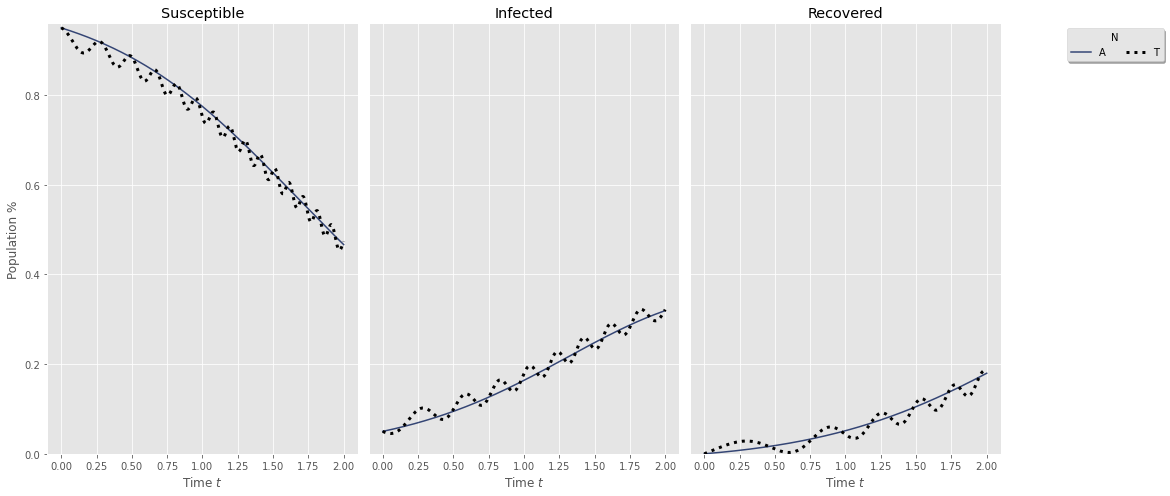

In [50]:
# Multiplot
fig, ax = plt.subplots(1, 3, figsize=(16, 7))
ax[1].set_yticklabels([]);
ax[2].set_yticklabels([]);
for tick in ax[1].yaxis.get_major_ticks():
    tick.tick1line.set_visible(False)
for tick in ax[2].yaxis.get_major_ticks():
    tick.tick1line.set_visible(False)
    '''tick.tick2line.set_visible(False)
    tick.label1.set_visible(False)
    tick.label2.set_visible(False)'''

k = colours_GD.shape[0] - 1
''''''
#for N, ρ in States.items():
#    Tₑ = concatenate([[0],0.5*(chebpts1(N-2)+1) * T,[T]])
    
# Susceptible
ax[0].plot(Tₑ, ρᴬᵈᵃᵖᵗⁱᵛᵉ[0]/n, color = colours_GD[k], alpha = 0.8, label = 'A')

# Infected
ax[1].plot(Tₑ, ρᴬᵈᵃᵖᵗⁱᵛᵉ[1]/n, color = colours_GD[k], alpha = 0.8, label = 'A')

# Recovered
ax[2].plot(Tₑ, ρᴬᵈᵃᵖᵗⁱᵛᵉ[2]/n, color = colours_GD[k], alpha = 0.8, label = 'A')
    
#    k -= 1
''''''
    
# Add target
ax[0].plot(Tₑ, ρ̂[0]/n, ':', c='black', linewidth=3, label = 'T')
ax[1].plot(Tₑ, ρ̂[1]/n, ':', c='black', linewidth=3, label = 'T')
ax[2].plot(Tₑ, ρ̂[2]/n, ':', c='black', linewidth=3, label = 'T')

ax[0].set_ylim([0.0, (Sₒ+2)/n]);    ax[0].set_xlabel(r'Time $t$');    ax[0].set_title(r'Susceptible')
ax[1].set_ylim([0.0, (Sₒ+2)/n]);    ax[1].set_xlabel(r'Time $t$');    ax[1].set_title(r'Infected')
ax[2].set_ylim([0.0, (Sₒ+2)/n]);    ax[2].set_xlabel(r'Time $t$');    ax[2].set_title(r'Recovered')

ax[0].set_ylabel('Population %')

plt.legend(bbox_to_anchor=(1.54, 1), loc="upper right", shadow=True, ncol=2, title='N')
fig.tight_layout()
#plt.savefig('Outputs/Grid – States – BFGS.pdf', bbox_inches='tight', pad_inches=0)

# Joint plots

In [51]:
PGD_final   = pd.read_pickle('Outputs/Grid – PGD - Every.pkl')
FISTA_final = pd.read_pickle('Outputs/Grid – FISTA - Every.pkl')
BFGS_final  = pd.read_pickle('Outputs/Grid – LMBFGS - Every.pkl')

In [42]:
print(BFGS_final[['it','β','γ','obj','Ter','norms-ℓ_2']].to_latex())

\begin{tabular}{lrrrlrr}
\toprule
{} &   it &         β &         γ &                    obj &       Ter &  norms-ℓ\_2 \\
\midrule
50    &   60 &  0.010308 &  0.520410 &  0.0008969149499817409 &  0.995332 &   0.006911 \\
100   &   69 &  0.010313 &  0.521204 &  0.0009054824489446784 &  0.992704 &   0.023372 \\
500   &   49 &  0.010313 &  0.521224 &  0.0009054815508661847 &  0.992396 &   0.023587 \\
1000  &  157 &  0.010313 &  0.521224 &  0.0009054815538797387 &  0.992398 &   0.023585 \\
5000  &   66 &  0.010313 &  0.521224 &  0.0009054815750266751 &  0.992399 &   0.023591 \\
10000 &   69 &  0.010313 &  0.521222 &  0.0009054815395007777 &  0.992403 &   0.023579 \\
50000 &   61 &  0.010313 &  0.521223 &  0.0009054815415909558 &  0.992402 &   0.023579 \\
\bottomrule
\end{tabular}



/var/folders/1g/8szp6jr52h1byl43_1lx7zlm0000gn/T/ipykernel_43817/2191649946.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(BFGS_final[['it','β','γ','obj','Ter','norms-ℓ_2']].to_latex())


In [52]:
PGD_final

,it,obj,time,β,γ,df_β,df_γ,Ter,norms-ℓ_1,norms-ℓ_2,norms-max,norms-min
50,29,0.012194,0.447377,0.009008,0.277432,-0.233839,-0.098395,11.212316,0.166117,0.179391,0.233839,0.098395
100,89,0.010564,1.331134,0.009103,0.294687,0.239180,-0.091347,10.379323,0.165264,0.181041,0.239180,0.091347
500,60,0.010915,0.582769,0.009087,0.290863,-0.318920,-0.091764,10.567314,0.205342,0.234660,0.318920,0.091764
1000,3120,0.004209,22.328763,0.009615,0.385074,-0.026925,-0.050652,6.179784,0.038789,0.040562,0.050652,0.026925
5000,64,0.011259,0.640891,0.009072,0.287195,-0.183659,-0.094438,10.748940,0.139048,0.146029,0.183659,0.094438
10000,222,0.004180,2.046466,0.009618,0.385646,-0.229306,-0.049625,6.153940,0.139466,0.165898,0.229306,0.049625
50000,134,0.011127,4.346245,0.009077,0.288596,-0.218706,-0.093442,10.679272,0.156074,0.168172,0.218706,0.093442


In [53]:
FISTA_final

,it,obj,time,β,γ,df_β,df_γ,Ter,norms-ℓ_1,norms-ℓ_2,norms-max,norms-min
50,1339,0.000897,11.133460,0.010311,0.521248,-0.023557,1.075104e-04,0.985154,0.011832,0.016657,0.023557,1.075104e-04
100,2555,0.000905,17.841580,0.010312,0.521215,0.000006,-3.409263e-06,0.986374,0.000004,0.000005,0.000006,3.409263e-06
500,211,0.002789,3.325432,0.009804,0.417468,16.825558,-8.097395e-02,4.763125,8.453266,11.897604,16.825558,8.097395e-02
1000,211,0.002807,3.467929,0.009729,0.418087,17.021462,-8.180546e-02,4.679672,8.551634,12.036130,17.021462,8.180546e-02
5000,1388,0.000905,14.753981,0.010312,0.521236,0.000077,-5.514926e-07,0.986607,0.000039,0.000054,0.000077,5.514926e-07
10000,211,0.002827,4.269357,0.009719,0.418023,17.030958,-8.218898e-02,4.688615,8.556574,12.042846,17.030958,8.218898e-02
50000,213,0.002811,12.384790,0.009850,0.418166,16.905040,-7.891997e-02,4.837193,8.491980,11.953798,16.905040,7.891997e-02


In [54]:
BFGS_final

,it,obj,time,β,γ,df_β,df_γ,t_k,Ter,norms-ℓ_1,norms-ℓ_2,norms-max,norms-min
50,60,0.0008969149499817409,3.848850,0.010308,0.520410,0.009769,-0.000333,0.5,0.995332,0.005051,0.006911,0.009769,0.000333
100,69,0.0009054824489446784,3.390466,0.010313,0.521204,0.033052,-0.000173,0.5,0.992704,0.016612,0.023372,0.033052,0.000173
500,49,0.0009054815508661847,2.721317,0.010313,0.521224,0.033356,-0.000166,0.5,0.992396,0.016761,0.023587,0.033356,0.000166
1000,157,0.0009054815538797387,3.689146,0.010313,0.521224,0.033354,-0.000166,0.5,0.992398,0.016760,0.023585,0.033354,0.000166
5000,66,0.0009054815750266751,3.877591,0.010313,0.521224,0.033363,-0.000166,0.5,0.992399,0.016764,0.023591,0.033363,0.000166
10000,69,0.0009054815395007777,4.404882,0.010313,0.521222,0.033345,-0.000166,0.5,0.992403,0.016755,0.023579,0.033345,0.000166
50000,61,0.0009054815415909558,8.301566,0.010313,0.521223,0.033345,-0.000166,0.5,0.992402,0.016756,0.023579,0.033345,0.000166


Select colours:

In [57]:
CMap = get_cmap('YlGnBu')
colours_BFGS = CMap(linspace(0.3,1,Stats.shape[0]))

CMap = get_cmap('YlOrBr')
colours_GD = CMap(linspace(0.3,1,Stats.shape[0]))

CMap = get_cmap('RdPu')
colours_FISTA = CMap(linspace(0.3,1,Stats.shape[0]))

Attained objective:

[]

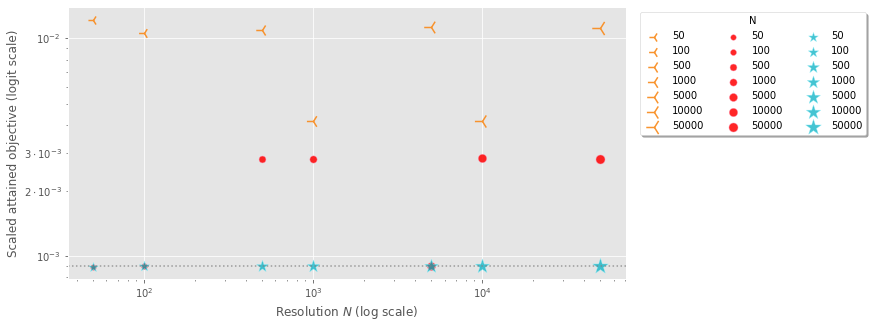

In [84]:
# Plot objective against N
plt.figure(figsize=(10,5))

k = colours_GD.shape[0] - 1
for N, fᵥ in PGD_final['obj'].iteritems():
    # PGD
    plt.scatter(N, fᵥ, color='xkcd:pale gold', facecolor = colours_GD[2],
             alpha = 0.95, marker='3', s = 25*np.log(N+10), label = N)
    k -= 1
    
k = colours_FISTA.shape[0] - 1
for N, fᵥ in FISTA_final['obj'].iteritems():
    # FISTA
    plt.scatter(N, fᵥ, color='r', edgecolor = "xkcd:rosa",
             alpha =0.85, marker='.', s = 30*np.log(N+10), label = N)
    k -= 1
    
k = colours_BFGS.shape[0] - 1
for N, fᵥ in BFGS_final['obj'].iteritems():
    # BFGS
    plt.scatter(N, fᵥ, color='xkcd:turquoise blue', edgecolor = "xkcd:robin's egg blue",
         alpha =0.75, marker='*', s = 25*np.log(N+10), label = N)
    k -= 1
    
plt.axhline(y=Stats_Adapt['obj'].values[0].item(), color='grey', linestyle=':', alpha=0.75)
    
plt.xscale('log')
plt.yscale('logit')
plt.legend(bbox_to_anchor=(1.44, 1), loc="upper right", shadow=True, ncol=3, facecolor='w', title='N')

plt.xlabel(r'Resolution $N$ (log scale)');    plt.ylabel('Scaled attained objective (logit scale)')
plt.savefig('Outputs/Grid – Objectives.pdf', bbox_inches='tight', pad_inches=0)
plt.plot()

BFGS attains the best objectives, but the adaptive step method actually obtains a lower objective except when the resolution is bad. If we re-evaluate the point that attained such value with a higher resolution, we obtain a greater objective.

In [59]:
BFGS_final['obj'].values.astype(np.float64)[1:].min(), Stats_Adapt['obj'].values[0].item()

(0.0009054815395007777, 0.0009054774017227151)

In [60]:
obj_eval(asarray([BFGS_final['β'].values[0],BFGS_final['γ'].values[0]]))

(array(0.00090557), array([ 0.02180919, -0.00037375]))

[]

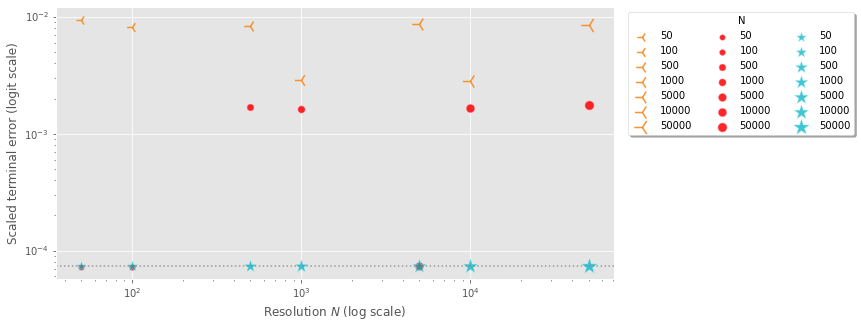

In [85]:
# Plot objective against N
plt.figure(figsize=(10,5))

k = colours_GD.shape[0] - 1
for N, fᵥ in PGD_final['Ter'].iteritems():
    # PGD
    plt.scatter(N, 3*(fᵥ/n)**2, color='xkcd:pale gold', facecolor = colours_GD[2],
             alpha = 0.95, marker='3', s = 25*np.log(N+10), label = N)
    k -= 1
    
k = colours_FISTA.shape[0] - 1
for N, fᵥ in FISTA_final['Ter'].iteritems():
    # FISTA
    plt.scatter(N, 3*(fᵥ/n)**2, color='r', edgecolor = "xkcd:rosa",
             alpha =0.85, marker='.', s = 30*np.log(N+10), label = N)
    k -= 1
    
k = colours_BFGS.shape[0] - 1
for N, fᵥ in BFGS_final['Ter'].iteritems():
    # BFGS
    plt.scatter(N, 3*(fᵥ/n)**2, color='xkcd:turquoise blue', edgecolor = "xkcd:robin's egg blue",
         alpha =0.75, marker='*', s = 25*np.log(N+10), label = N)
    k -= 1
    
plt.axhline(y=3*(Stats_Adapt['Ter'].values[0].item()/n)**2, color='grey', linestyle=':', alpha=0.75)
    
plt.xscale('log')
plt.yscale('logit')
plt.legend(bbox_to_anchor=(1.44, 1), loc="upper right", shadow=True, ncol=3, facecolor='w', title='N')

plt.xlabel(r'Resolution $N$ (log scale)');    plt.ylabel('Scaled terminal error (logit scale)')
plt.savefig('Outputs/Grid – Terminal.pdf', bbox_inches='tight', pad_inches=0)
plt.plot()

In [62]:
BFGS_final['Ter'].values.astype(np.float64)[:].min(), Stats_Adapt['Ter'].values[0].item()

(0.99239645684436, 0.9924023914948521)

In [63]:
obj_eval(asarray([BFGS_final['β'].values[3],BFGS_final['γ'].values[3]]))

(array(0.00090548), array([ 0.03335648, -0.00016572]))

In [64]:
print(norm(ρ[:,-1] - ρ̂[:,-1])/(3**0.5))

0.9923976386913365


Display minimisers:

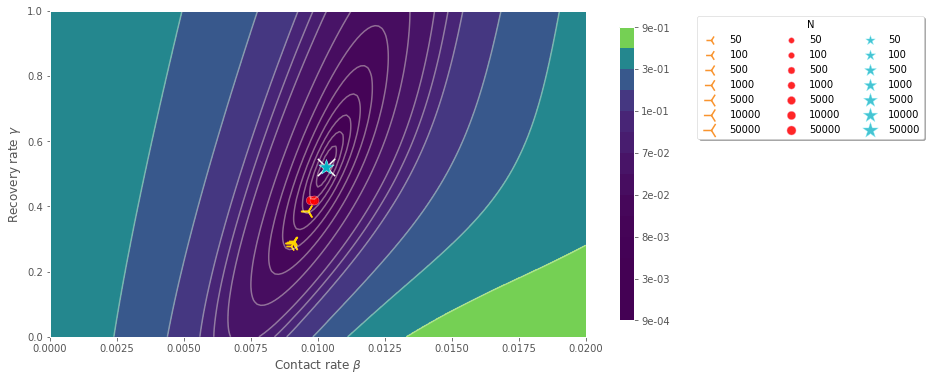

In [67]:
# Contour plot objective functional
X_c, Y_c = meshgrid(β_axis, γ_axis, indexing='ij')
ℓ = linspace((Misfit).min(),(Misfit).max(),15)
ℓ = append( 0.086, np.logspace( np.log( Misfit[Misfit>0.0].min() ), np.log( Misfit.max() ), 
                num=14, endpoint=True, base=np.e) )
ℓ.sort()

#fig, ax = plt.subplots(ncols=1, figsize=(50, 20))
fig, ax = plt.subplots(ncols=1, figsize=(12, 6))
cp = ax.contourf(X_c, Y_c, Misfit, ℓ)
ax.contour(cp, colors='#FFFFE6', alpha= 0.4)                                  # Contour plot
#plt.scatter(β_0, γ_0, s=20, c='#FFFFE6', marker='s')          # Display min
#plt.scatter(ᾱ[0], ᾱ[1], s=20, c='#FFFFE6', marker='x')          # Display min


# Best estimated minimiser
βᴬᵈᵃᵖᵗⁱᵛᵉ, γᴬᵈᵃᵖᵗⁱᵛᵉ = Stats_Adapt['β'][0], Stats_Adapt['γ'][0]
plt.scatter( βᴬᵈᵃᵖᵗⁱᵛᵉ, γᴬᵈᵃᵖᵗⁱᵛᵉ, s=300, marker='x', color='white' )


# Approximate minimisers using PGD
k_row = colours_GD.shape[0] - 1
for row in PGD_final.iterrows():
    N = row[0]
    
    scatter = plt.scatter(row[1]['β'], row[1]['γ'], color='xkcd:pale gold', facecolor = colours_GD[2],#'gold',
                          #color = colours_GD[k_row],
         alpha = 0.95, marker='3', s = 25*np.log(N+10), label = N)

    k_row -= 1

# Approximate minimisers using FISTA
k_row = colours_FISTA.shape[0] - 1
for row in FISTA_final.iterrows():
    N = row[0]
    
    scatter = plt.scatter(row[1]['β'], row[1]['γ'], color = 'r', #colours_FISTA[k_row], 
                          #edgecolor = "xkcd:robin's egg blue",
                          edgecolor = "xkcd:rosa",
         alpha =0.85, marker='.', s = 30*np.log(N+10), label = N)

    k_row -= 1

# Approximate minimisers using BFGS
k_row = colours_BFGS.shape[0] - 1
for row in BFGS_final.iterrows():
    N = row[0]
    
    scatter = plt.scatter(row[1]['β'], row[1]['γ'], color='xkcd:turquoise blue', 
                          #color = colours_BFGS[k_row], 
                          edgecolor = "xkcd:robin's egg blue",
         alpha =0.75, marker='*', s = 25*np.log(N+10), label = N)

    k_row -= 1
    
    
# Approximate minimisers using PGD
k_row = colours_GD.shape[0] - 1
for row in PGD_final.iterrows():
    N = row[0]
    
    scatter = plt.scatter(row[1]['β'], row[1]['γ'], color='xkcd:pale gold', facecolor = 'gold',
                          #color = colours_GD[k_row],
         alpha = 0.95, marker='3', s = 25*np.log(N+10))

    k_row -= 1








fig.colorbar(cp, shrink=0.9, format='%.0e')
ax.set_xlabel(r'Contact rate $\beta$');    ax.set_ylabel(r'Recovery rate $\gamma$')
#plt.title(r'Plot of objective evaluations for ${f(\alpha)}/{n^2}$ over finer grid')
#plt.xscale('symlog')
#plt.xscale('symlog', linthresh = 1.5e-2)
plt.legend(bbox_to_anchor=(1.64, 1), loc="upper right", shadow=True, ncol=3, facecolor='w', title='N')
plt.show()
fig.savefig('Outputs/Grid – Contour[a].pdf', bbox_inches='tight', pad_inches=0)

Represent the same for gradient:

Plot of derivative evaluations for ‖∂f(α)‖/n² over finer grid


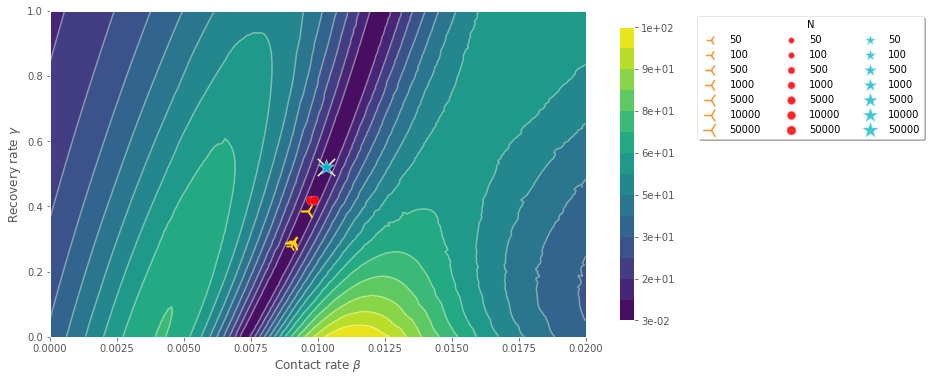

In [81]:
# Contour plot
print('Plot of derivative evaluations for ‖∂f(α)‖/n² over finer grid')

X_c, Y_c = meshgrid(β_axis, γ_axis, indexing='ij')
ℓ = linspace((Misfit_d).min(),(Misfit_d).max(),15)
#ℓ = np.logspace( np.log( Misfit_d.min() ), np.log( Misfit_d.max() ), num=15, endpoint=True, base=np.e)

#fig, ax = plt.subplots(ncols=1, figsize=(50, 20))
fig, ax = plt.subplots(ncols=1, figsize=(12, 6))
cp = ax.contourf(X_c, Y_c, Misfit_d, ℓ)
ax.contour(cp, colors='#FFFFE6', alpha= 0.4)                                  # Contour plot
fig.colorbar(cp, shrink=0.9, format='%.0e')

# Best estimated minimiser
βᴬᵈᵃᵖᵗⁱᵛᵉ, γᴬᵈᵃᵖᵗⁱᵛᵉ = Stats_Adapt['β'][0], Stats_Adapt['γ'][0]
plt.scatter( βᴬᵈᵃᵖᵗⁱᵛᵉ, γᴬᵈᵃᵖᵗⁱᵛᵉ, s=300, marker='x', color='white' )


# Approximate minimisers using PGD
k_row = colours_GD.shape[0] - 1
for row in PGD_final.iterrows():
    N = row[0]
    
    scatter = plt.scatter(row[1]['β'], row[1]['γ'], color='xkcd:pale gold', facecolor = colours_GD[2],#'gold',
                          #color = colours_GD[k_row],
         alpha = 0.95, marker='3', s = 25*np.log(N+10), label = N)

    k_row -= 1

# Approximate minimisers using FISTA
k_row = colours_FISTA.shape[0] - 1
for row in FISTA_final.iterrows():
    N = row[0]
    
    scatter = plt.scatter(row[1]['β'], row[1]['γ'], color = 'r', #colours_FISTA[k_row], 
                          #edgecolor = "xkcd:robin's egg blue",
                          edgecolor = "xkcd:rosa",
         alpha =0.85, marker='.', s = 30*np.log(N+10), label = N)

    k_row -= 1

# Approximate minimisers using BFGS
k_row = colours_BFGS.shape[0] - 1
for row in Stats.iterrows():
    N = row[0]
    
    scatter = plt.scatter(row[1]['β'], row[1]['γ'], color='xkcd:turquoise blue', 
                          #color = colours_BFGS[k_row], 
                          edgecolor = "xkcd:robin's egg blue",
         alpha =0.75, marker='*', s = 25*np.log(N+10), label = N)

    k_row -= 1
    
    
# Approximate minimisers using PGD
k_row = colours_GD.shape[0] - 1
for row in PGD_final.iterrows():
    N = row[0]
    
    scatter = plt.scatter(row[1]['β'], row[1]['γ'], color='xkcd:pale gold', facecolor = 'gold',
                          #color = colours_GD[k_row],
         alpha = 0.95, marker='3', s = 25*np.log(N+10))

    k_row -= 1




ax.set_xlabel(r'Contact rate $\beta$');    ax.set_ylabel(r'Recovery rate $\gamma$')
#plt.title(r'Plot of objective evaluations for ${f(\alpha)}/{n^2}$ over finer grid')
#plt.xscale('log')
#plt.xscale('symlog', linthresh = 3e-1)
#plt.xscale('symlog', linthresh = 1.5e-2)
plt.legend(bbox_to_anchor=(1.64, 1), loc="upper right", shadow=True, ncol=3, facecolor='w', title='N')
plt.show()
fig.savefig('Outputs/Grid – Contour[b].pdf', bbox_inches='tight', pad_inches=0)

Plot of derivative evaluations for ∂ᵦf(α)/n² over finer grid


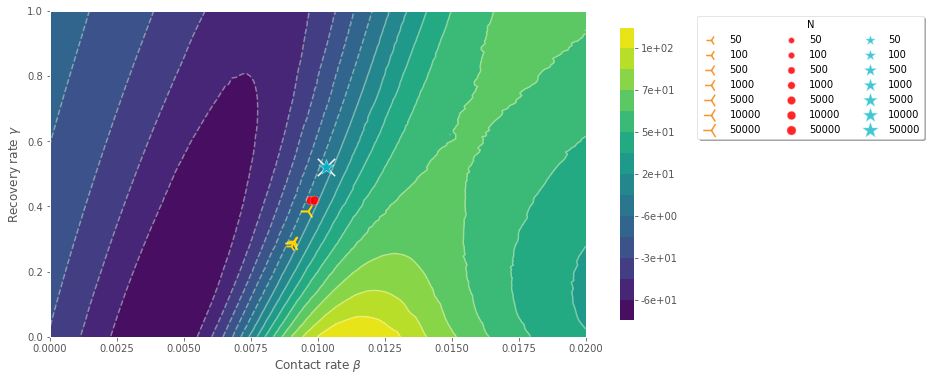

In [86]:
# Contour plot
print('Plot of derivative evaluations for ∂ᵦf(α)/n² over finer grid')

X_c, Y_c = meshgrid(β_axis, γ_axis, indexing='ij')
ℓ = linspace((Misfit_dβ).min(),(Misfit_dβ).max(),15)
#ℓ = np.logspace( np.log( Misfit_d.min() ), np.log( Misfit_d.max() ), num=15, endpoint=True, base=np.e)

#fig, ax = plt.subplots(ncols=1, figsize=(50, 20))
fig, ax = plt.subplots(ncols=1, figsize=(12, 6))
cp = ax.contourf(X_c, Y_c, Misfit_dβ, ℓ)
ax.contour(cp, colors='#FFFFE6', alpha= 0.4)                                  # Contour plot
fig.colorbar(cp, shrink=0.9, format='%.0e')

# Best estimated minimiser
βᴬᵈᵃᵖᵗⁱᵛᵉ, γᴬᵈᵃᵖᵗⁱᵛᵉ = Stats_Adapt['β'][0], Stats_Adapt['γ'][0]
plt.scatter( βᴬᵈᵃᵖᵗⁱᵛᵉ, γᴬᵈᵃᵖᵗⁱᵛᵉ, s=300, marker='x', color='white' )


# Approximate minimisers using PGD
k_row = colours_GD.shape[0] - 1
for row in PGD_final.iterrows():
    N = row[0]
    
    scatter = plt.scatter(row[1]['β'], row[1]['γ'], color='xkcd:pale gold', facecolor = colours_GD[2],#'gold',
                          #color = colours_GD[k_row],
         alpha = 0.95, marker='3', s = 25*np.log(N+10), label = N)

    k_row -= 1

# Approximate minimisers using FISTA
k_row = colours_FISTA.shape[0] - 1
for row in FISTA_final.iterrows():
    N = row[0]
    
    scatter = plt.scatter(row[1]['β'], row[1]['γ'], color = 'r', #colours_FISTA[k_row], 
                          #edgecolor = "xkcd:robin's egg blue",
                          edgecolor = "xkcd:rosa",
         alpha =0.85, marker='.', s = 30*np.log(N+10), label = N)

    k_row -= 1

# Approximate minimisers using BFGS
k_row = colours_BFGS.shape[0] - 1
for row in Stats.iterrows():
    N = row[0]
    
    scatter = plt.scatter(row[1]['β'], row[1]['γ'], color='xkcd:turquoise blue', 
                          #color = colours_BFGS[k_row], 
                          edgecolor = "xkcd:robin's egg blue",
         alpha =0.75, marker='*', s = 25*np.log(N+10), label = N)

    k_row -= 1
    
    
# Approximate minimisers using PGD
k_row = colours_GD.shape[0] - 1
for row in PGD_final.iterrows():
    N = row[0]
    
    scatter = plt.scatter(row[1]['β'], row[1]['γ'], color='xkcd:pale gold', facecolor = 'gold',
                          #color = colours_GD[k_row],
         alpha = 0.95, marker='3', s = 25*np.log(N+10))

    k_row -= 1




ax.set_xlabel(r'Contact rate $\beta$');    ax.set_ylabel(r'Recovery rate $\gamma$')
#plt.title(r'Plot of objective evaluations for ${f(\alpha)}/{n^2}$ over finer grid')
#plt.xscale('log')
#plt.xscale('symlog', linthresh = 3e-1)
#plt.xscale('symlog', linthresh = 1.5e-2)
plt.legend(bbox_to_anchor=(1.64, 1), loc="upper right", shadow=True, ncol=3, facecolor='w', title='N')
plt.show()
#fig.savefig('Outputs/Regularisation – Contour[b].pdf', bbox_inches='tight', pad_inches=0)

Plot of derivative evaluations for ∂ᵧf(α)/n² over finer grid


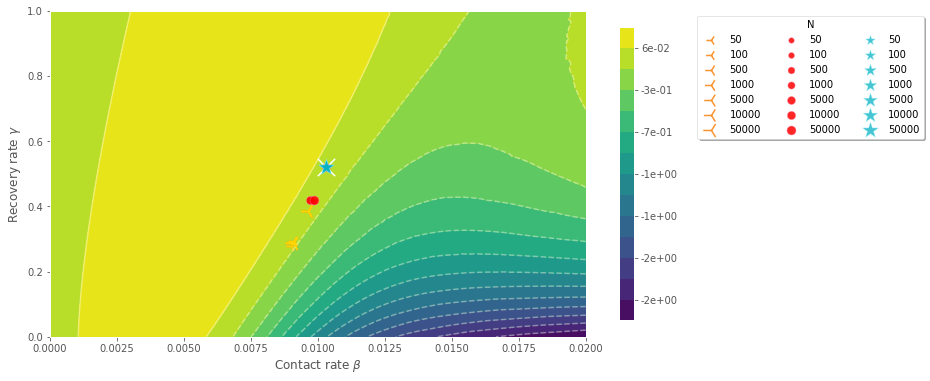

In [87]:
# Contour plot
print('Plot of derivative evaluations for ∂ᵧf(α)/n² over finer grid')

X_c, Y_c = meshgrid(β_axis, γ_axis, indexing='ij')
ℓ = linspace((Misfit_dγ).min(),(Misfit_dγ).max(),15)
#ℓ = np.logspace( np.log( Misfit_d.min() ), np.log( Misfit_d.max() ), num=15, endpoint=True, base=np.e)

#fig, ax = plt.subplots(ncols=1, figsize=(50, 20))
fig, ax = plt.subplots(ncols=1, figsize=(12, 6))
cp = ax.contourf(X_c, Y_c, Misfit_dγ, ℓ)
ax.contour(cp, colors='#FFFFE6', alpha= 0.4)                                  # Contour plot
fig.colorbar(cp, shrink=0.9, format='%.0e')

# Best estimated minimiser
βᴬᵈᵃᵖᵗⁱᵛᵉ, γᴬᵈᵃᵖᵗⁱᵛᵉ = Stats_Adapt['β'][0], Stats_Adapt['γ'][0]
plt.scatter( βᴬᵈᵃᵖᵗⁱᵛᵉ, γᴬᵈᵃᵖᵗⁱᵛᵉ, s=300, marker='x', color='white' )


# Approximate minimisers using PGD
k_row = colours_GD.shape[0] - 1
for row in PGD_final.iterrows():
    N = row[0]
    
    scatter = plt.scatter(row[1]['β'], row[1]['γ'], color='xkcd:pale gold', facecolor = colours_GD[2],#'gold',
                          #color = colours_GD[k_row],
         alpha = 0.95, marker='3', s = 25*np.log(N+10), label = N)

    k_row -= 1

# Approximate minimisers using FISTA
k_row = colours_FISTA.shape[0] - 1
for row in FISTA_final.iterrows():
    N = row[0]
    
    scatter = plt.scatter(row[1]['β'], row[1]['γ'], color = 'r', #colours_FISTA[k_row], 
                          #edgecolor = "xkcd:robin's egg blue",
                          edgecolor = "xkcd:rosa",
         alpha =0.85, marker='.', s = 30*np.log(N+10), label = N)

    k_row -= 1

# Approximate minimisers using BFGS
k_row = colours_BFGS.shape[0] - 1
for row in Stats.iterrows():
    N = row[0]
    
    scatter = plt.scatter(row[1]['β'], row[1]['γ'], color='xkcd:turquoise blue', 
                          #color = colours_BFGS[k_row], 
                          edgecolor = "xkcd:robin's egg blue",
         alpha =0.75, marker='*', s = 25*np.log(N+10), label = N)

    k_row -= 1
    
    
# Approximate minimisers using PGD
k_row = colours_GD.shape[0] - 1
for row in PGD_final.iterrows():
    N = row[0]
    
    scatter = plt.scatter(row[1]['β'], row[1]['γ'], color='xkcd:pale gold', facecolor = 'gold',
                          #color = colours_GD[k_row],
         alpha = 0.95, marker='3', s = 25*np.log(N+10))

    k_row -= 1




ax.set_xlabel(r'Contact rate $\beta$');    ax.set_ylabel(r'Recovery rate $\gamma$')
#plt.title(r'Plot of objective evaluations for ${f(\alpha)}/{n^2}$ over finer grid')
#plt.xscale('log')
#plt.xscale('symlog', linthresh = 3e-1)
#plt.xscale('symlog', linthresh = 1.5e-2)
plt.legend(bbox_to_anchor=(1.64, 1), loc="upper right", shadow=True, ncol=3, facecolor='w', title='N')
plt.show()
#fig.savefig('Outputs/Regularisation – Contour[b].pdf', bbox_inches='tight', pad_inches=0)

In [101]:
Tₑ = concatenate([[0],0.5*(chebpts1(50000-2)+1) * T,[T]])
# Setup target
ρ̂  = ρ̄(Tₑ)           # Sample target
dρ̂ = dρ̄(Tₑ)          # Sample derivative of target (just for resolution of interporlator)
ρ̄ₙ = CubicHermiteSpline(Tₑ, ρ̂, dρ̂, axis=-1)        # Create interpolator for the sampled data

In [102]:
def obj_eval_T(α):                  # ** Eval f' ** #
    '''
        Evaluate state, compute adjoint, and return objective and derivative
    '''
    scaling = True
    
    # Compute state α
    ρ_sol = solve_ivp(SIR, [0, T], [Sₒ, Iₒ, Rₒ], args=α, t_eval = Tₑ, 
                      dense_output=True, vectorized=True)
    if ρ_sol['success'] != True:    print('Should re-evaluate for', ω)
    ρ = ρ_sol.y
    

    f = norm(ρ̂[:,-1] - ρ[:,-1])
    f /= (3**0.5)
    
    return f

In [103]:
# Finer evaluations
nβ, nγ = 151, 151
Misfit_T = zeros([nβ, nγ])
β_axis = linspace(0.0,0.02,nβ)
γ_axis = linspace(0.0,1.0,nγ)
for (i,β) in enumerate(β_axis):
    if i % 10 == 0:
        print(i,β)
    for (j,γ) in enumerate(γ_axis):
        df = obj_eval_T(asarray([β,γ]))
        Misfit_T[i,j] = df

0 0.0
10 0.0013333333333333335
20 0.002666666666666667
30 0.004
40 0.005333333333333334
50 0.006666666666666667
60 0.008
70 0.009333333333333334
80 0.010666666666666668
90 0.012
100 0.013333333333333334
110 0.014666666666666668
120 0.016
130 0.017333333333333333
140 0.018666666666666668
150 0.02


Plot of derivative evaluations for terminal error over finer grid


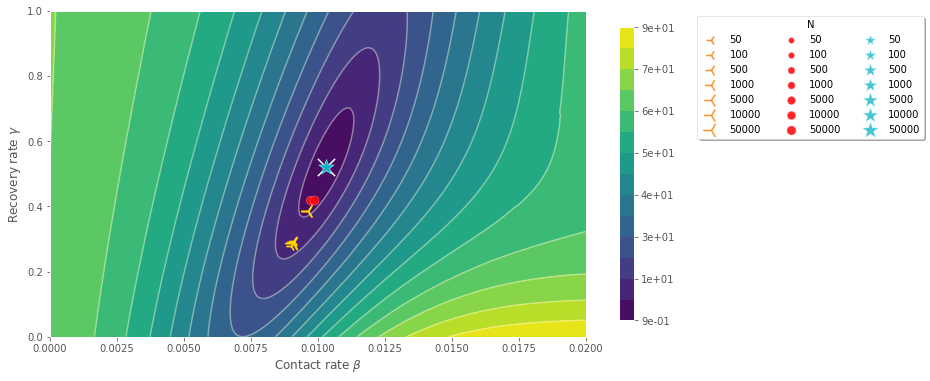

In [99]:
# Contour plot
print('Plot of derivative evaluations for terminal error over finer grid')

X_c, Y_c = meshgrid(β_axis, γ_axis, indexing='ij')
ℓ = linspace((Misfit_T).min(),(Misfit_T).max(),15)
#ℓ = np.logspace( np.log( Misfit_T.min() ), np.log( Misfit_d.max() ), num=15, endpoint=True, base=np.e)

#fig, ax = plt.subplots(ncols=1, figsize=(50, 20))
fig, ax = plt.subplots(ncols=1, figsize=(12, 6))
cp = ax.contourf(X_c, Y_c, Misfit_T, ℓ)
ax.contour(cp, colors='#FFFFE6', alpha= 0.4)                                  # Contour plot
fig.colorbar(cp, shrink=0.9, format='%.0e')

# Best estimated minimiser
βᴬᵈᵃᵖᵗⁱᵛᵉ, γᴬᵈᵃᵖᵗⁱᵛᵉ = Stats_Adapt['β'][0], Stats_Adapt['γ'][0]
plt.scatter( βᴬᵈᵃᵖᵗⁱᵛᵉ, γᴬᵈᵃᵖᵗⁱᵛᵉ, s=300, marker='x', color='white' )


# Approximate minimisers using PGD
k_row = colours_GD.shape[0] - 1
for row in PGD_final.iterrows():
    N = row[0]
    
    scatter = plt.scatter(row[1]['β'], row[1]['γ'], color='xkcd:pale gold', facecolor = colours_GD[2],#'gold',
                          #color = colours_GD[k_row],
         alpha = 0.95, marker='3', s = 25*np.log(N+10), label = N)

    k_row -= 1

# Approximate minimisers using FISTA
k_row = colours_FISTA.shape[0] - 1
for row in FISTA_final.iterrows():
    N = row[0]
    
    scatter = plt.scatter(row[1]['β'], row[1]['γ'], color = 'r', #colours_FISTA[k_row], 
                          #edgecolor = "xkcd:robin's egg blue",
                          edgecolor = "xkcd:rosa",
         alpha =0.85, marker='.', s = 30*np.log(N+10), label = N)

    k_row -= 1

# Approximate minimisers using BFGS
k_row = colours_BFGS.shape[0] - 1
for row in Stats.iterrows():
    N = row[0]
    
    scatter = plt.scatter(row[1]['β'], row[1]['γ'], color='xkcd:turquoise blue', 
                          #color = colours_BFGS[k_row], 
                          edgecolor = "xkcd:robin's egg blue",
         alpha =0.75, marker='*', s = 25*np.log(N+10), label = N)

    k_row -= 1
    
    
# Approximate minimisers using PGD
k_row = colours_GD.shape[0] - 1
for row in PGD_final.iterrows():
    N = row[0]
    
    scatter = plt.scatter(row[1]['β'], row[1]['γ'], color='xkcd:pale gold', facecolor = 'gold',
                          #color = colours_GD[k_row],
         alpha = 0.95, marker='3', s = 25*np.log(N+10))

    k_row -= 1




ax.set_xlabel(r'Contact rate $\beta$');    ax.set_ylabel(r'Recovery rate $\gamma$')
#plt.title(r'Plot of objective evaluations for ${f(\alpha)}/{n^2}$ over finer grid')
#plt.xscale('log')
#plt.xscale('symlog', linthresh = 3e-1)
#plt.xscale('symlog', linthresh = 1.5e-2)
plt.legend(bbox_to_anchor=(1.64, 1), loc="upper right", shadow=True, ncol=3, facecolor='w', title='N')
plt.show()
fig.savefig('Outputs/Grid – Contour[c].pdf', bbox_inches='tight', pad_inches=0)

---